Notebook created on 25/06/2025 to investigate EUl small domain MAR3.14-MPI sim

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

veg_mar = ['No Veg.', # 0
           'Crops Low', # 1
           'Crops Medium', # 2
           'Crops High', # 3
           'Grass low', # 4
           'Grass Medium', # 5
           'Grass High', # 6
           'Broadleaf Low', # 7
           'Broadleaf Medium', # 8
           'Broadleaf High', # 9
           'Needle Low', # 10
           'Needle Medium', # 11
           'Needle High', # 12
           'City'] # 13

In [3]:
ds_small = xr.open_dataset('/bettik/castelli/MARout/EUh/h01/2015/ICE.h01.2015.01.01-31.nc')[["LON","LAT","SH","FRV","VEG"]]
ds_smallish = xr.open_dataset('/bettik/castelli/MARout/EUm/m01/2014/ICE.m01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]
ds_big = xr.open_dataset('/bettik/castelli/MARout/EUn/n01/2014/ICE.n01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

alps_month = np.repeat(alps[np.newaxis,:,:],12,axis=0)


In [5]:
def open_monthly_data_ave(vars,year,month,days_in_month,sim,timestep_in_hours = 2,imin = 32,imax = -30,jmin = 20,jmax = -15,whichpath='castelli',
                         ds_sect = ds_small,combine=False):
    # average of mosaics
    # example of vars : ["GF","SWU","SWD","HAcc","LWU","LWD","SHF","LHF","HA_col","MBm","MBr","MBmTop","MBrTop","MB","MBrr","SAbs_v","SAbs","CC","CU","CM","CD",
    #                    "QQz","TTz","ST","SWt"]
    if whichpath=='castelli':
        path = '/bettik/castelli/MARout/EU'
    else:
        path = '/bettik/menegozm/MARout/EU'
    letter = sim[0]
    code = sim[1:]
    path = path+letter+'/'+letter+code+'/'+year+'/ICE.'+letter+code+'.'+year+'.'

    #ds_day = xr.open_dataset(path+letter+'/'+letter+code+'/'+year+'/ICE.'+letter+code+'.'+year+'.'+month+'.01-'+days_in_month+'.nc')[vars].isel(x=slice(imin,imax),
    #                                                                                                                                                y=slice(jmin,jmax))
    if combine:
        files = []
        for i in range(len(month)):
            files.append(path+month[i]+'.01-'+days_in_month[i]+'.nc')
        ds_day = xr.open_mfdataset(files,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')[vars].isel(x=slice(imin,imax),
                                                                                                                                                y=slice(jmin,jmax))
    else:
        ds_day = xr.open_dataset(path+month+'.01-'+days_in_month+'.nc')[vars].isel(x=slice(imin,imax),y=slice(jmin,jmax))
        
    # Melt
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*timestep_in_hours # 60*60*24 seconds in a day
    if('MBm' in vars):
        melt_MBm = ds_day.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100 # in mm = L.m**(-2) = kg.m**(-2) because for liquid water 1L=1kg
        ds_day_melt = melt_MBm * Lf / t_timestep # kg.m**(-2) * J.kg**(-1) / s = J/s.m**(-2) = W.m**(-2)
        ds_day['melt'] = -ds_day_melt # minus sign because energy is LOST by surface in order to melt snow
    if('MBr' in vars):
        freez_MBr = ds_day.MBr.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBr.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MBr.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez = freez_MBr * Lf / t_timestep
        ds_day['freeze'] = ds_day_freez
    if('MBmTop' in vars):
        melt_MBm_top = ds_day.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_melt_top = melt_MBm_top * Lf / t_timestep
        ds_day['melt_top'] = -ds_day_melt_top
    if('MBrTop' in vars):
        freez_MBr_top = ds_day.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez_top = freez_MBr_top * Lf / t_timestep
        ds_day['freeze_top'] = ds_day_freez_top
    if('MB' in vars):
        average_snow = ds_day.MB.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MB.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MB.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day['MBave'] = average_snow
    if('SWD' in vars and 'SWU' in vars):
        ds_day['NSW'] = ds_day.SWD - ds_day.SWU
    if('LWD' in vars and 'LWU' in vars):
        ds_day['NLW'] = ds_day.LWD - ds_day.LWU
    if('TTz' in vars):
        ds_day['TT2'] = ds_day.TTz.sel(ztqlev=2.0)
    if('SWt' in vars):
        ds_day['SWt'] = -ds_day['SWt'] # - sign because the energy transmitted to lower layers is LOST by the surface
    if('MBrr' in vars and 'MBsf' in vars):
        ds_day['precip'] = ds_day.MBrr + ds_day.MBsf
    if('SWD' in vars and 'SWU' in vars and 'LWD' in vars and 'LWU' in vars and 'SHF' in vars and 'LHF' in vars and 'MBmTop' in vars and 'MBrTop' in vars and 'GF' in vars
       and 'HAcc' in vars and 'SWt' in vars):
        ds_day_surf_balance = ds_day.NSW + ds_day.NLW + ds_day.SHF + ds_day.LHF + ds_day.melt_top + ds_day.freeze_top + ds_day.GF + ds_day.HAcc + ds_day.SWt
        ds_day['Surf_Bal'] = ds_day_surf_balance

    return ds_day

In [6]:
def plot_comparison(list_ds,months,min,max,colormap,label_var,suptitle_var,ds_size=ds_small,N=11,rows=2):

    f, axs = pplt.subplots(proj='cyl',axwidth=2,ncols=4,nrows=rows,axheight=1.)

    for mon in range(len(list_ds)):    
        ax=axs[mon]
        m = ax.pcolormesh(ds_size.LON,ds_size.LAT,list_ds[mon],levels=np.linspace(min,max,N),cmap=colormap)
        ax.format(title=months[mon])

    f.colorbar(m,label= label_var,labelsize='large',ticklabelsize='large')
    axs.format(**multiplot_format,suptitle=suptitle_var)

In [7]:
# MARv3.10
name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP585'
sim = 'EUy'
sim2 = 'EUy'
data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly
year = 2015

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy2015 = xr.open_dataset(ssp585_path)


ds_EUy2015['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy2015["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy2015["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy2015["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy2015["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy2015["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy2015["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy2015["precip"] = ds_EUy2015["MBrr"] + ds_EUy2015["MBsf"]

In [8]:
scenario = 'HIST'
year = 2014

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy2014 = xr.open_dataset(ssp585_path)


ds_EUy2014['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy2014["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy2014["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy2014["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy2014["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy2014["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy2014["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy2014["precip"] = ds_EUy2014["MBrr"] + ds_EUy2014["MBsf"]

### MAR-MPI : big domain MARv3.10 vs small domain MARv3.14

l01 : marmagic_mod parameters are the same as for my first simulations where I didn't touch them, which is :
humidity_magic = 15.
cloud_magic = 0.1
correction_humidity_boundary = 0.0
rain_snow_limit = 273.15

l02 : marmagic_mod parameters are the same as for MARv3.10 sims done by Julien and Martin (see /bettik/menegozm/MARout/Julien/EUy/y01/code/MARmagic.inc)
humidity_magic = 20.
cloud_magic = 0.00
correction_humidity_boundary = 0.0
rain_snow_limit = 273.15

l03 : humidity_magic = 15.
cloud_magic = 0.1
correction_humidity_boundary = 0.1
rain_snow_limit = 273.15

In [10]:
#vars_list = ["SWU","SWD","LWU","LWD","SHF","LHF","MB","MBmTop","MBrTop","GF","HAcc","SWt","MBrr","MBsf","CC","QQz","TTz","ST","TTp"]
vars_list = ["SWU","SWD","CC","QQz","TTz","ST"]
ds_EUl012015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='l01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUl022015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='l02',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUl032015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02'],days_in_month=['31','28'],sim='l03',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUl042015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='l04',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm012015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds_smallish)

ds_EUn012015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01'],days_in_month=['31'],sim='n01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds)

vars_list = ["MBrr","MBsf"]
ds_EUl012015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='l01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUl022015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='l02',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUl032015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02'],days_in_month=['31','28'],sim='l03',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUl042015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='l04',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm012015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04'],days_in_month=['31','28','31','30'],sim='m01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds_smallish)

ds_EUn012015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01'],days_in_month=['31'],sim='n01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds)

In [11]:
ds_EUl012015 = ds_EUl012015.resample(time='D').mean()
ds_EUl012015_precip = ds_EUl012015_precip.resample(time='D').sum()
ds_EUl012015_mon = ds_EUl012015.groupby("time.month").mean()
ds_EUl012015_precip_mon = ds_EUl012015_precip.groupby("time.month").mean()

ds_EUl022015 = ds_EUl022015.resample(time='D').mean()
ds_EUl022015_precip = ds_EUl022015_precip.resample(time='D').sum()
ds_EUl022015_mon = ds_EUl022015.groupby("time.month").mean()
ds_EUl022015_precip_mon = ds_EUl022015_precip.groupby("time.month").mean()

ds_EUl032015 = ds_EUl032015.resample(time='D').mean()
ds_EUl032015_precip = ds_EUl032015_precip.resample(time='D').sum()
ds_EUl032015_mon = ds_EUl032015.groupby("time.month").mean()
ds_EUl032015_precip_mon = ds_EUl032015_precip.groupby("time.month").mean()

ds_EUl042015 = ds_EUl042015.resample(time='D').mean()
ds_EUl042015_precip = ds_EUl042015_precip.resample(time='D').sum()
ds_EUl042015_mon = ds_EUl042015.groupby("time.month").mean()
ds_EUl042015_precip_mon = ds_EUl042015_precip.groupby("time.month").mean()

ds_EUm012015 = ds_EUm012015.resample(time='D').mean()
ds_EUm012015_precip = ds_EUm012015_precip.resample(time='D').sum()
ds_EUm012015_mon = ds_EUm012015.groupby("time.month").mean()
ds_EUm012015_precip_mon = ds_EUm012015_precip.groupby("time.month").mean()

ds_EUn012015 = ds_EUn012015.resample(time='D').mean()
ds_EUn012015_precip = ds_EUn012015_precip.resample(time='D').sum()
ds_EUn012015_mon = ds_EUn012015.groupby("time.month").mean()
ds_EUn012015_precip_mon = ds_EUn012015_precip.groupby("time.month").mean()

In [10]:
ds_small.coords['lon'] = ds_small.LON
ds_small.coords['lat'] = ds_small.LAT

ds_smallish.coords['lon'] = ds_smallish.LON
ds_smallish.coords['lat'] = ds_smallish.LAT

In [11]:
# Regridding MARv3.10 onto small domain

# MAR has a very slight difference in x and y positions of grid cells between MARgrid and the simulations, which will prevent the regridding. So have to do this :
lon_correct_xy = ds.LON # copy the incorrect lon/lat
lat_correct_xy = ds.LAT
#lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

lon_correct_xy["x"] = ("x", ds_EUy2015.x.values) # correct lon
lon_correct_xy["y"] = ("y", ds_EUy2015.y.values)

lat_correct_xy["x"] = ("x", ds_EUy2015.x.values) # correct lat
lat_correct_xy["y"] = ("y", ds_EUy2015.y.values)

ds_EUy2015.coords['lon'] = lon_correct_xy
ds_EUy2015.coords['lat'] = lat_correct_xy

ds_EUy2015_regridsmall = u.regrid(ds_EUy2015,ds_small,'bilinear',globe=True,periodic=False,reuse_weights=False)
ds_EUy2015_regridsmallish = u.regrid(ds_EUy2015,ds_smallish,'bilinear',globe=True,periodic=False,reuse_weights=False)

In [12]:
ds_EUy2015 = ds_EUy2015.assign_coords(x=ds_EUn012015.x)
ds_EUy2015 = ds_EUy2015.assign_coords(y=ds_EUn012015.y)

NameError: name 'ds_EUn012015' is not defined

In [ ]:
ds_EUy2015_month = ds_EUy2015.groupby("time.month").mean()
ds_EUy2015_regridsmall_month = ds_EUy2015_regridsmall.groupby("time.month").mean()
ds_EUy2015_regridsmallish_month = ds_EUy2015_regridsmallish.groupby("time.month").mean()

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

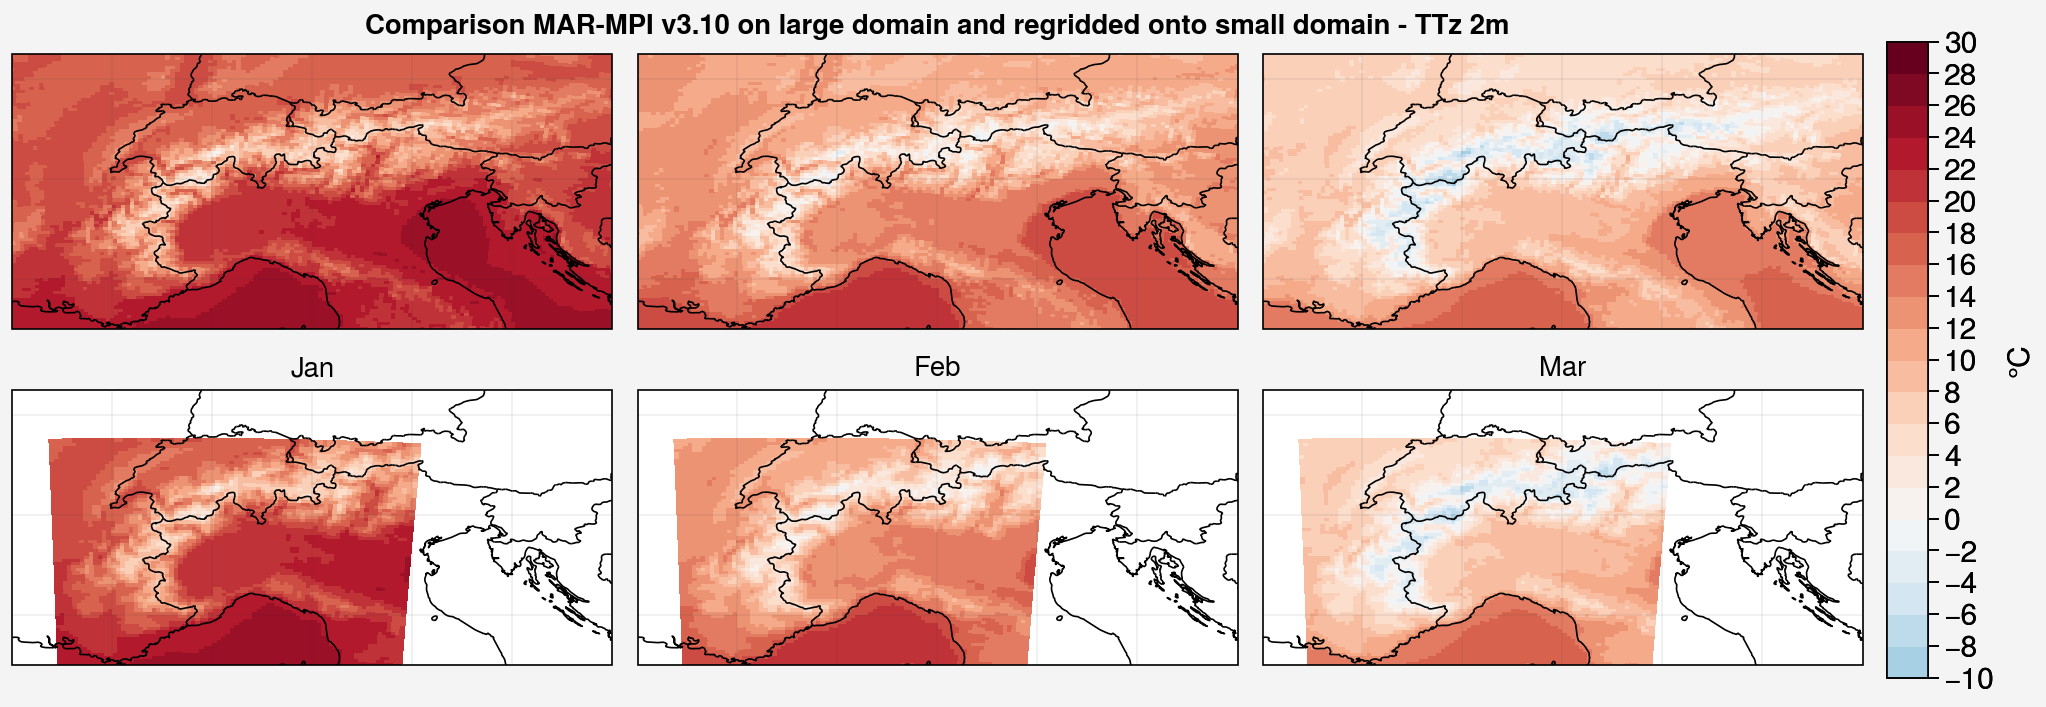

In [16]:
# Test to see if regrid worked well
# --------------------------------------------------

f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=3,nrows=2,axheight=1.5)

for mon in range(3):
    ax=axs[mon]
    m = ax.pcolormesh(ds.LON,ds.LAT,ds_EUy2015_month.TTz.isel(ztqlev=0)[mon+8],levels=np.linspace(-10,30,21),cmap='RdBu_r')
    
    ax=axs[mon+3]
    m = ax.pcolormesh(ds_small.LON,ds_small.LAT,ds_EUy2015_regridsmall_month.TTz.isel(ztqlev=0)[mon+8],levels=np.linspace(-10,30,21),cmap='RdBu_r')
    ax.format(title=months[mon])


f.colorbar(m,label= '°C',labelsize='large',ticklabelsize='large')
axs.format(**multiplot_format,suptitle='Comparison MAR-MPI v3.10 on large domain and regridded onto small domain - TTz 2m')


/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

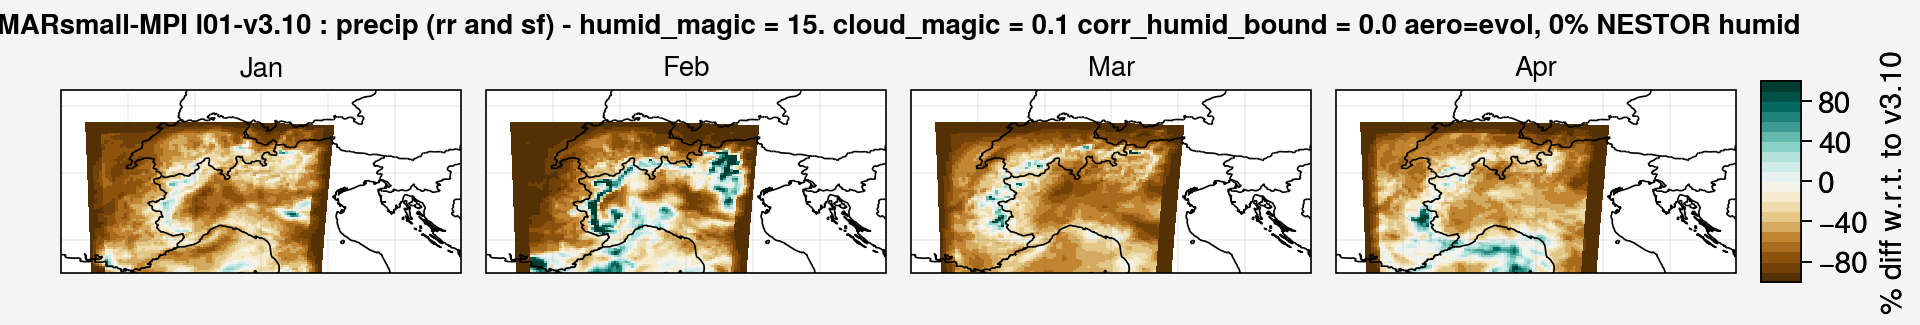

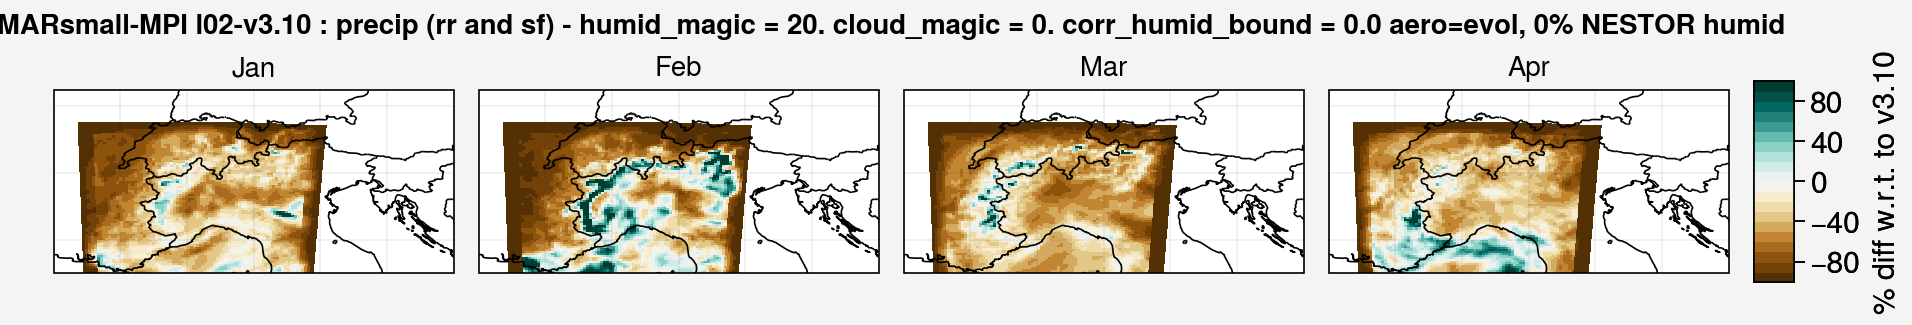

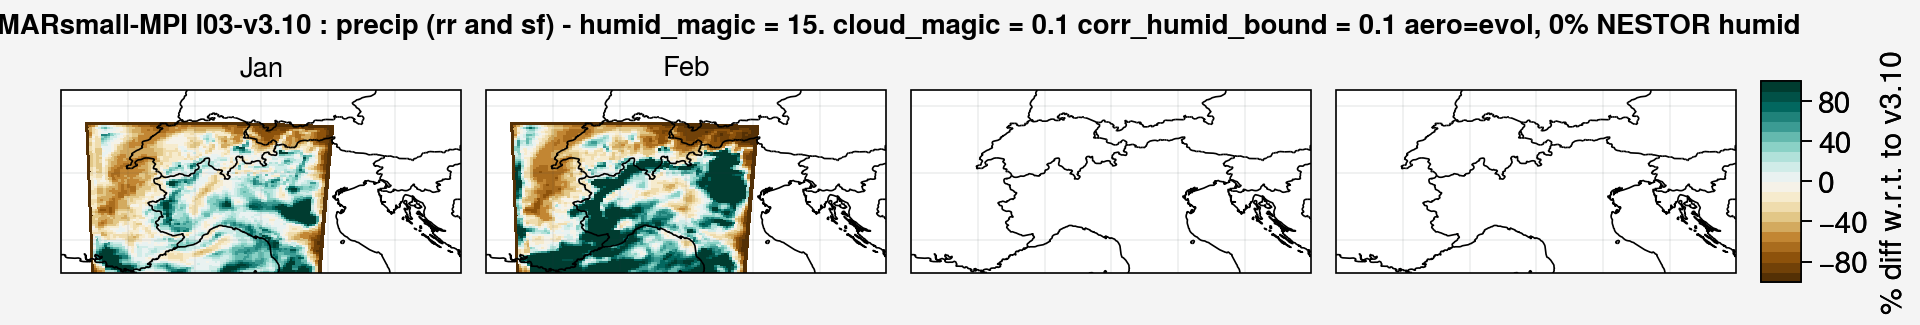

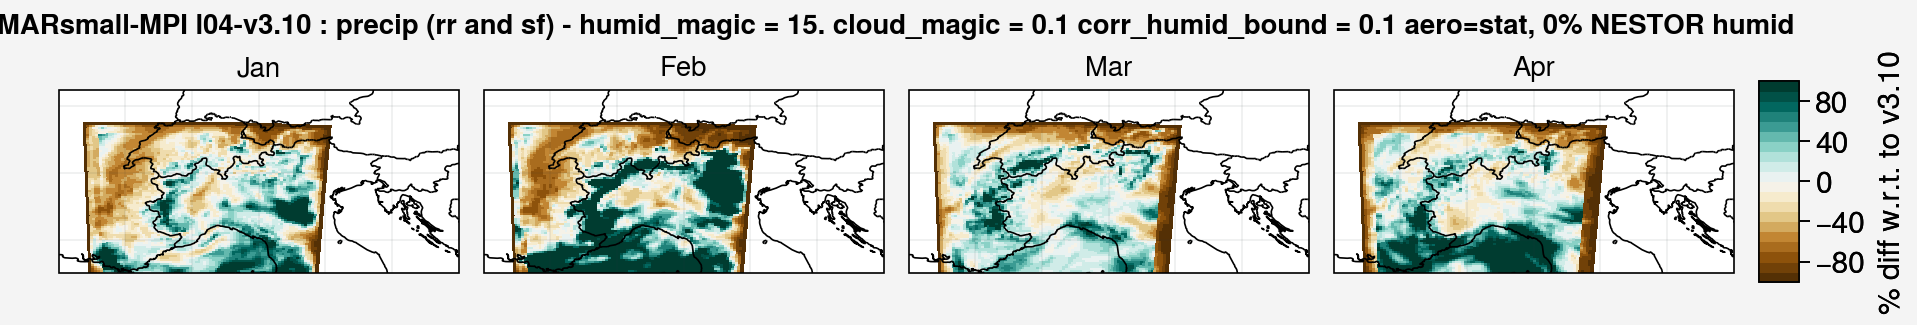

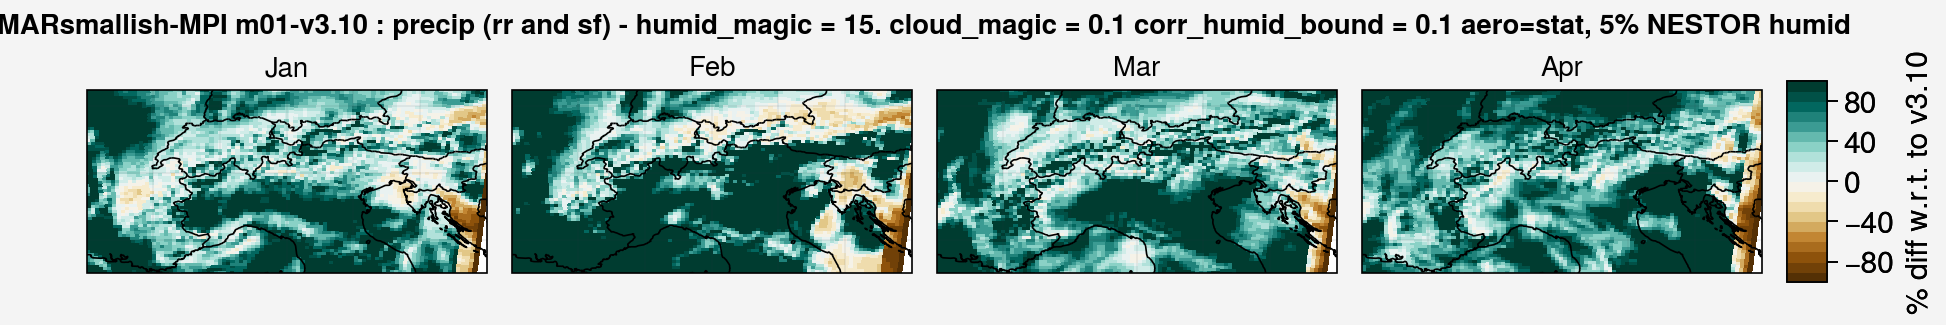

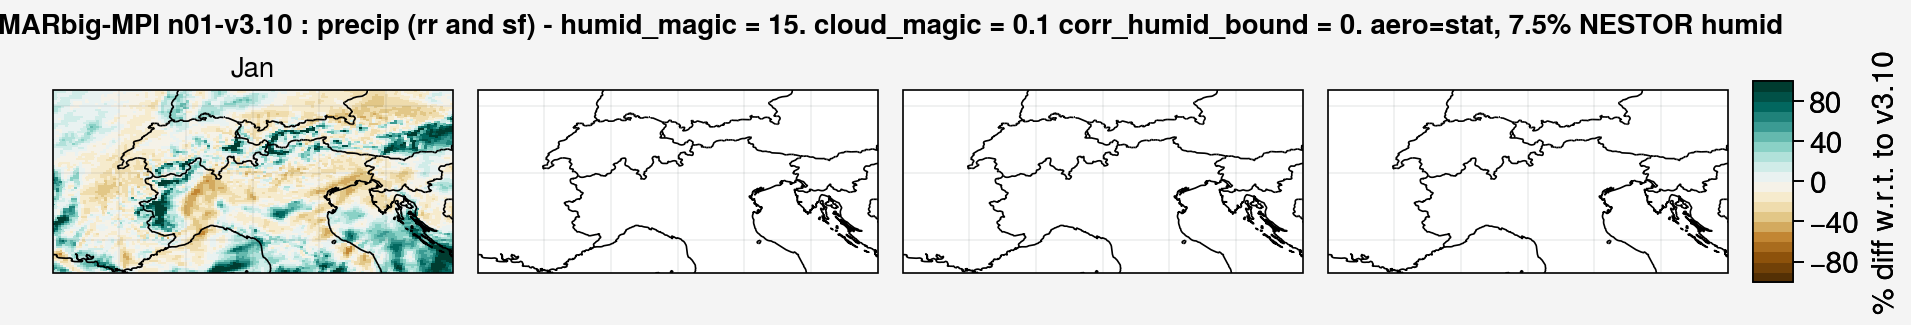

In [66]:
var = "precip"

#l01
plot_comparison(list_ds = [100*(ds_EUl012015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                                         100*(ds_EUl012015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1],
                                         100*(ds_EUl012015_precip_mon[var][2] - ds_EUy2015_regridsmall_month[var][2])/ds_EUy2015_regridsmall_month[var][2],
                                         100*(ds_EUl012015_precip_mon[var][3] - ds_EUy2015_regridsmall_month[var][3])/ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [100*(ds_EUl022015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                                         100*(ds_EUl022015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1],
                                         100*(ds_EUl022015_precip_mon[var][2] - ds_EUy2015_regridsmall_month[var][2])/ds_EUy2015_regridsmall_month[var][2],
                                         100*(ds_EUl022015_precip_mon[var][3] - ds_EUy2015_regridsmall_month[var][3])/ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI l02-v3.10 : precip (rr and sf) - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [100*(ds_EUl032015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                                         100*(ds_EUl032015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI l03-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [100*(ds_EUl042015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                                         100*(ds_EUl042015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1],
                                         100*(ds_EUl042015_precip_mon[var][2] - ds_EUy2015_regridsmall_month[var][2])/ds_EUy2015_regridsmall_month[var][2],
                                         100*(ds_EUl042015_precip_mon[var][3] - ds_EUy2015_regridsmall_month[var][3])/ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI l04-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [100*(ds_EUm012015_precip_mon[var][0] - ds_EUy2015_regridsmallish_month[var][0])/ds_EUy2015_regridsmallish_month[var][0],
                                         100*(ds_EUm012015_precip_mon[var][1] - ds_EUy2015_regridsmallish_month[var][1])/ds_EUy2015_regridsmallish_month[var][1],
                                         100*(ds_EUm012015_precip_mon[var][2] - ds_EUy2015_regridsmallish_month[var][2])/ds_EUy2015_regridsmallish_month[var][2],
                                         100*(ds_EUm012015_precip_mon[var][3] - ds_EUy2015_regridsmallish_month[var][3])/ds_EUy2015_regridsmallish_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [100*(ds_EUn012015_precip_mon[var][0] - ds_EUy2015_month[var][0])/ds_EUy2015_month[var][0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARbig-MPI n01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

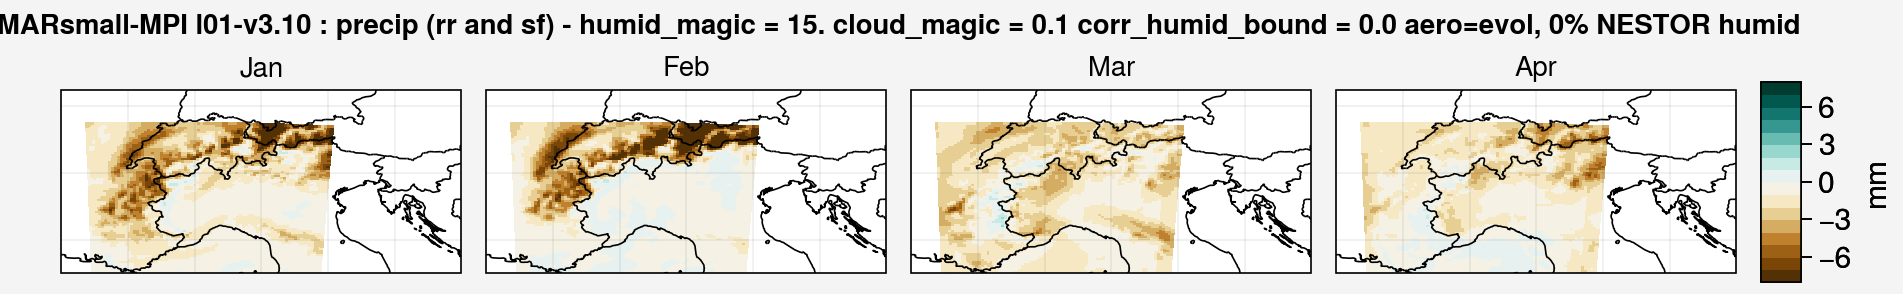

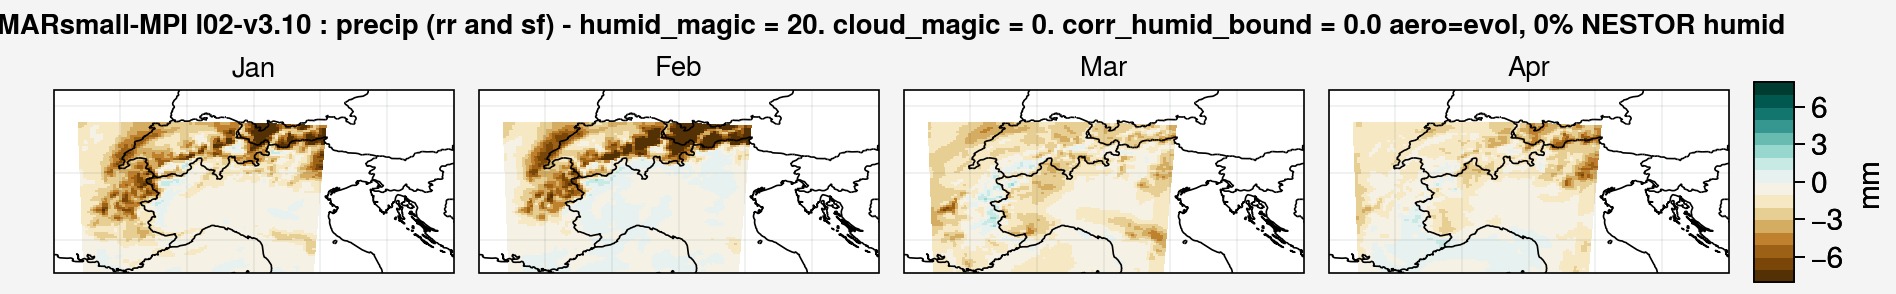

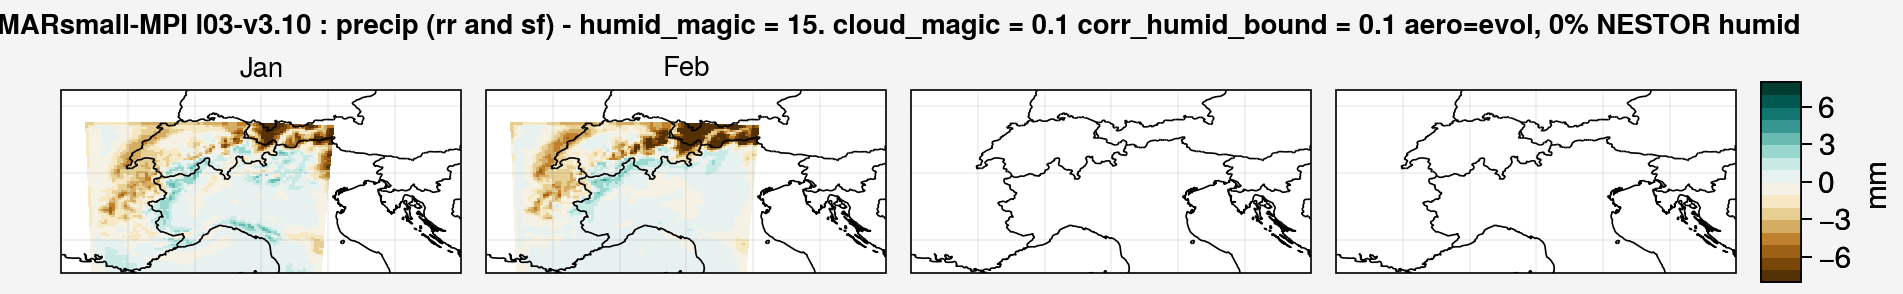

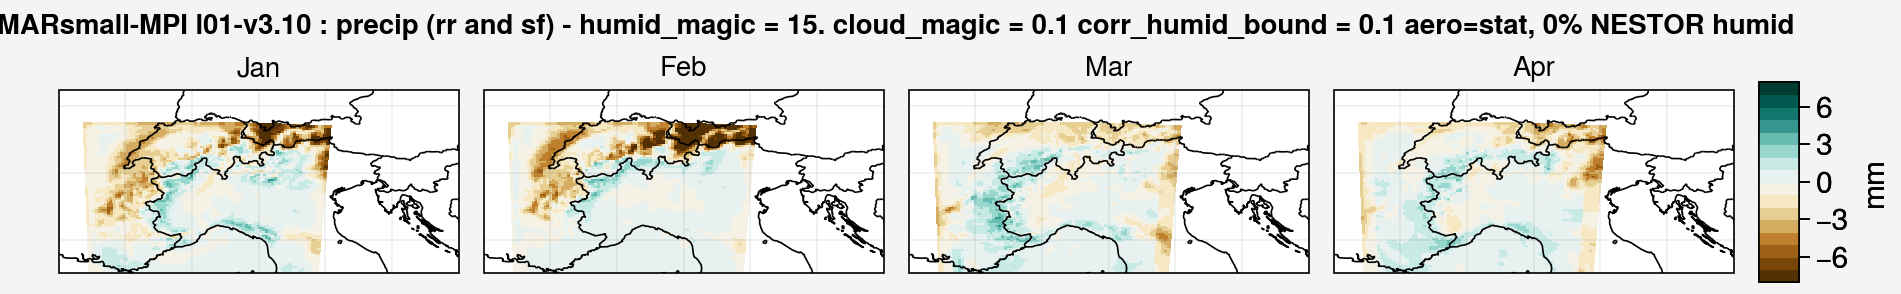

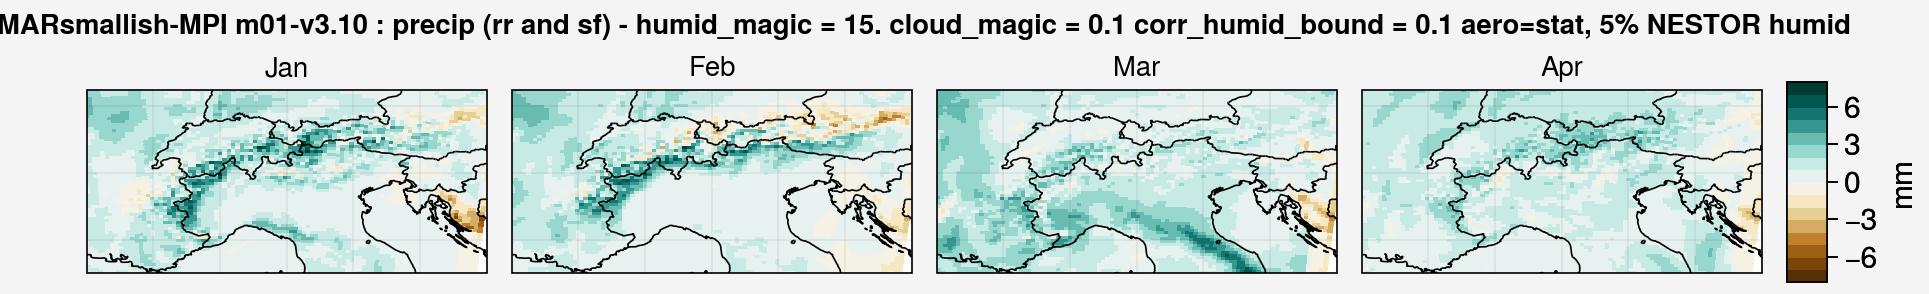

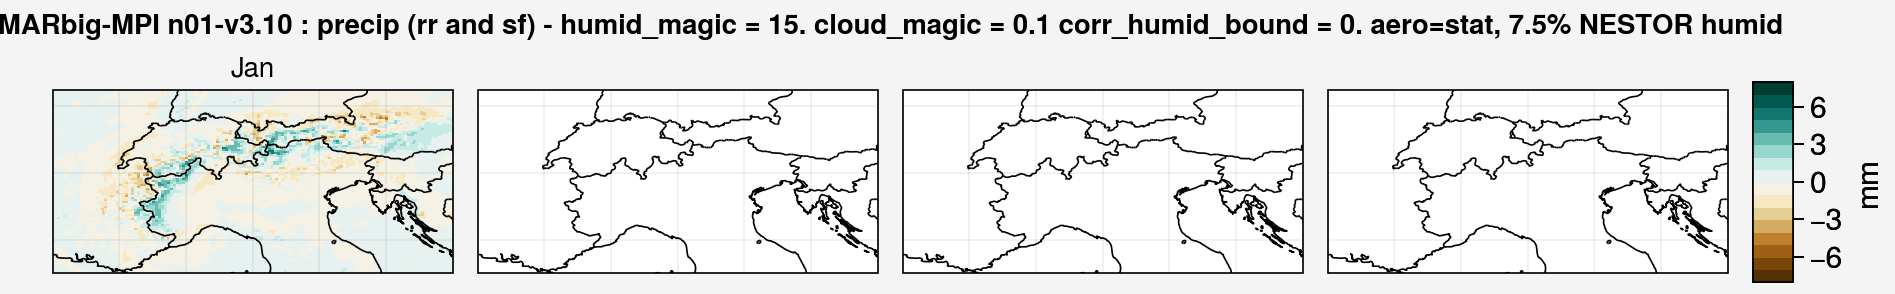

In [67]:
var = "precip"
minval = -8
maxval = 8
Nval = 17

#l01
plot_comparison(list_ds = [ds_EUl012015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl012015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl012015_precip_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl012015_precip_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [ds_EUl022015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl022015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl022015_precip_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl022015_precip_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARsmall-MPI l02-v3.10 : precip (rr and sf) - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [ds_EUl032015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl032015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARsmall-MPI l03-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [ds_EUl042015_precip_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl042015_precip_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl042015_precip_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl042015_precip_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [ds_EUm012015_precip_mon[var][0] - ds_EUy2015_regridsmallish_month[var][0],
                                         ds_EUm012015_precip_mon[var][1] - ds_EUy2015_regridsmallish_month[var][1],
                                         ds_EUm012015_precip_mon[var][2] - ds_EUy2015_regridsmallish_month[var][2],
                                         ds_EUm012015_precip_mon[var][3] - ds_EUy2015_regridsmallish_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [ds_EUn012015_precip_mon[var][0] - ds_EUy2015_month[var][0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARbig-MPI n01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

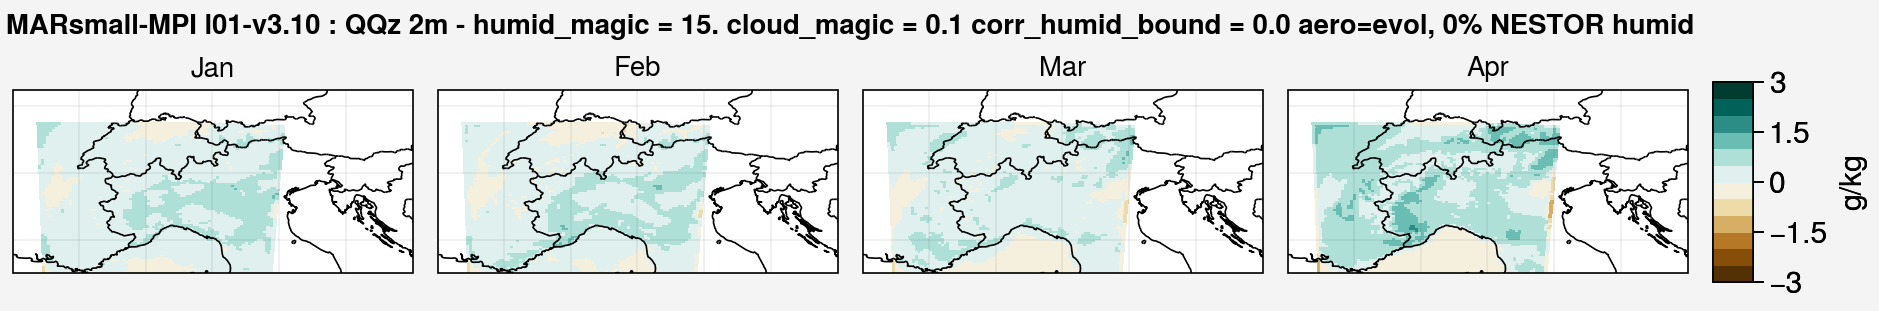

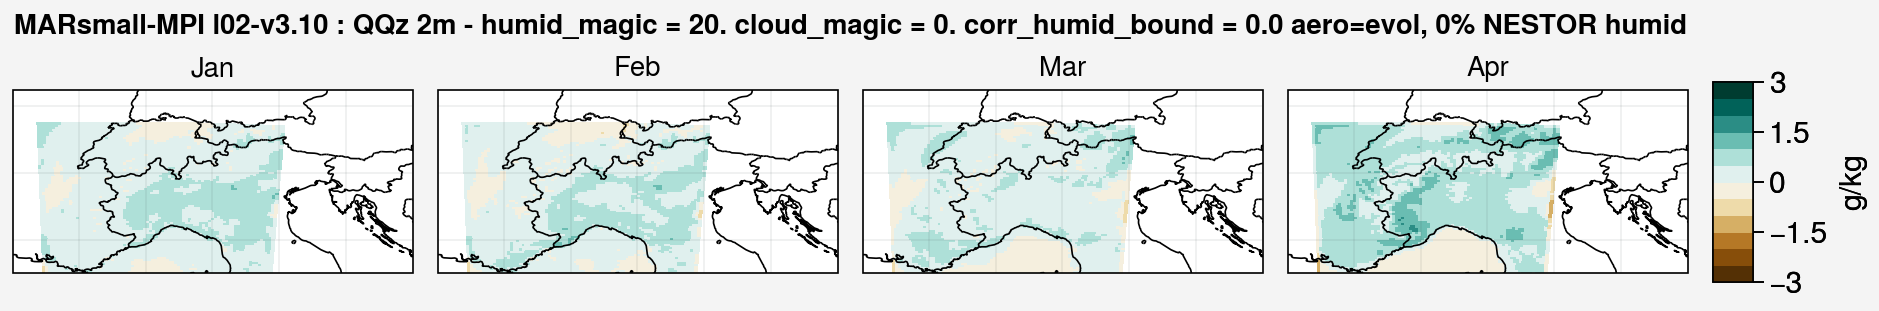

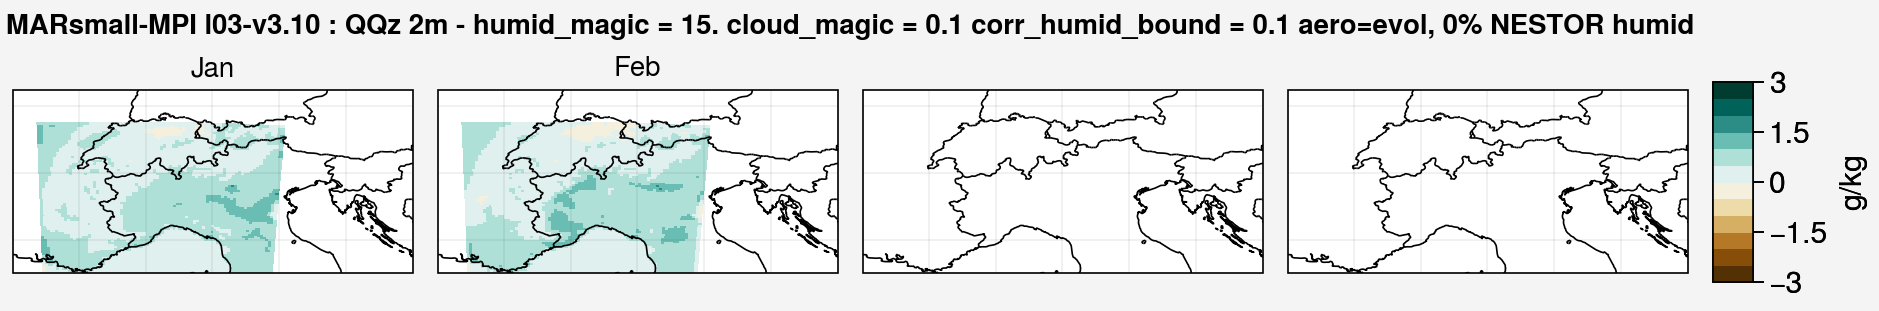

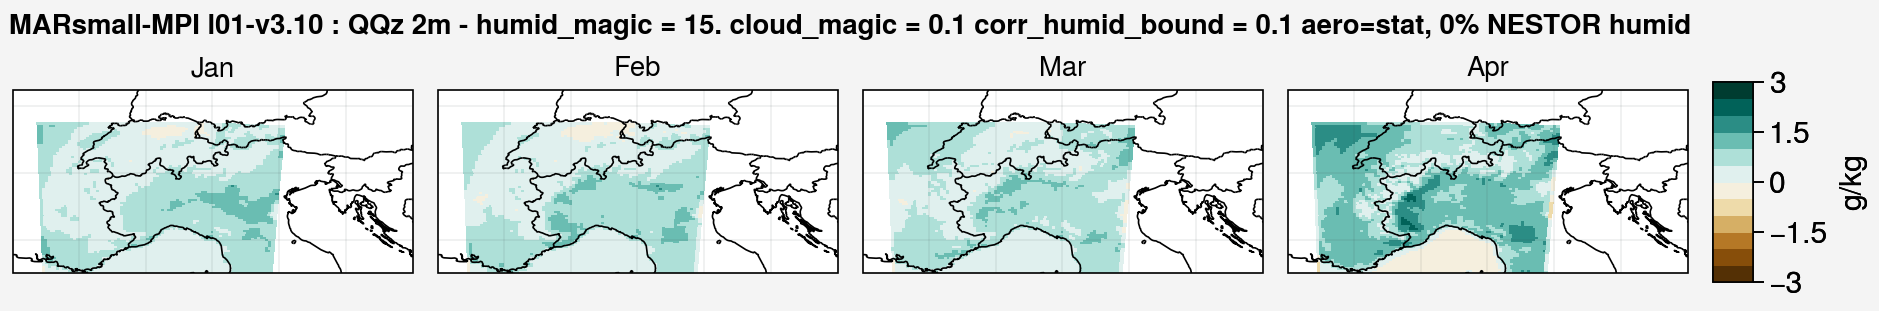

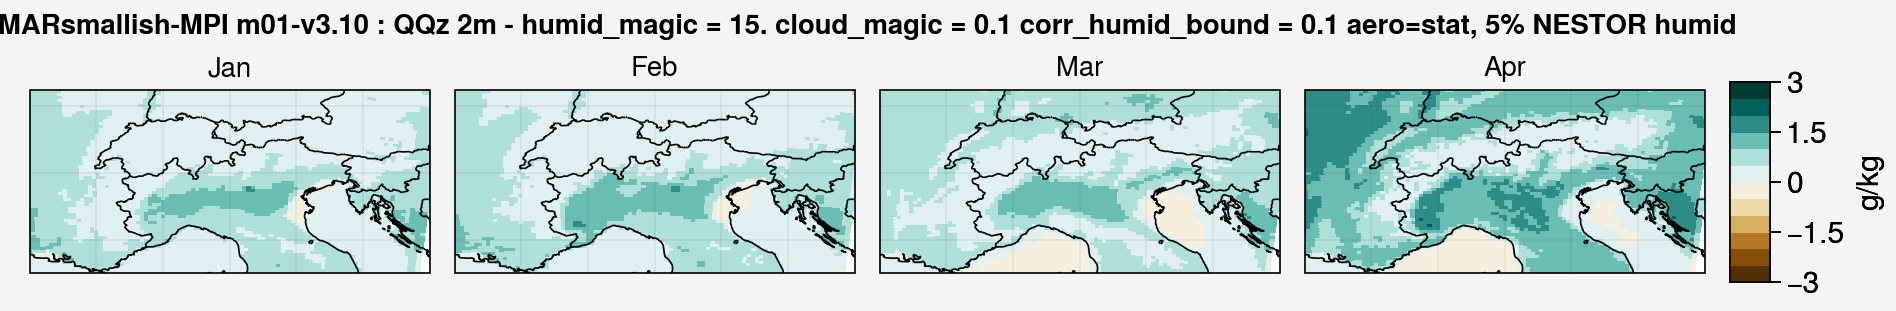

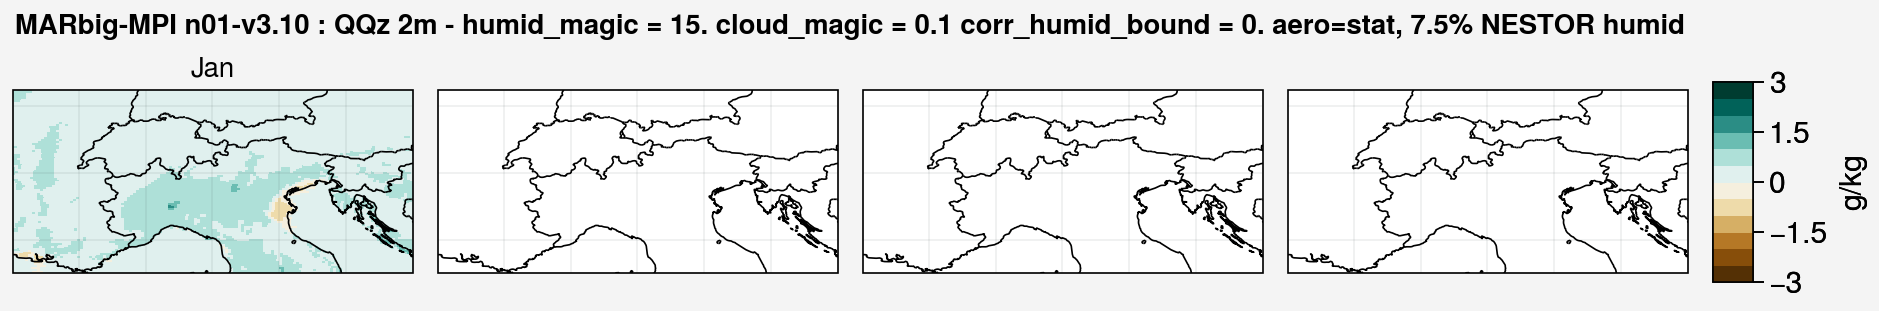

In [68]:
var = "QQz"
minval = -3
maxval = 3
Nval = 13

#l01
plot_comparison(list_ds = [ds_EUl012015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl012015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1],
                                         ds_EUl012015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[2],
                                         ds_EUl012015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [ds_EUl022015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl022015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1],
                                         ds_EUl022015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[2],
                                         ds_EUl022015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARsmall-MPI l02-v3.10 : QQz 2m - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [ds_EUl032015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl032015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARsmall-MPI l03-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [ds_EUl042015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl042015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1],
                                         ds_EUl042015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[2],
                                         ds_EUl042015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [ds_EUm012015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[0],
                                         ds_EUm012015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[1],
                                         ds_EUm012015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[2],
                                         ds_EUm012015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [ds_EUn012015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_month[var].isel(ztqlev=0)[0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARbig-MPI n01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

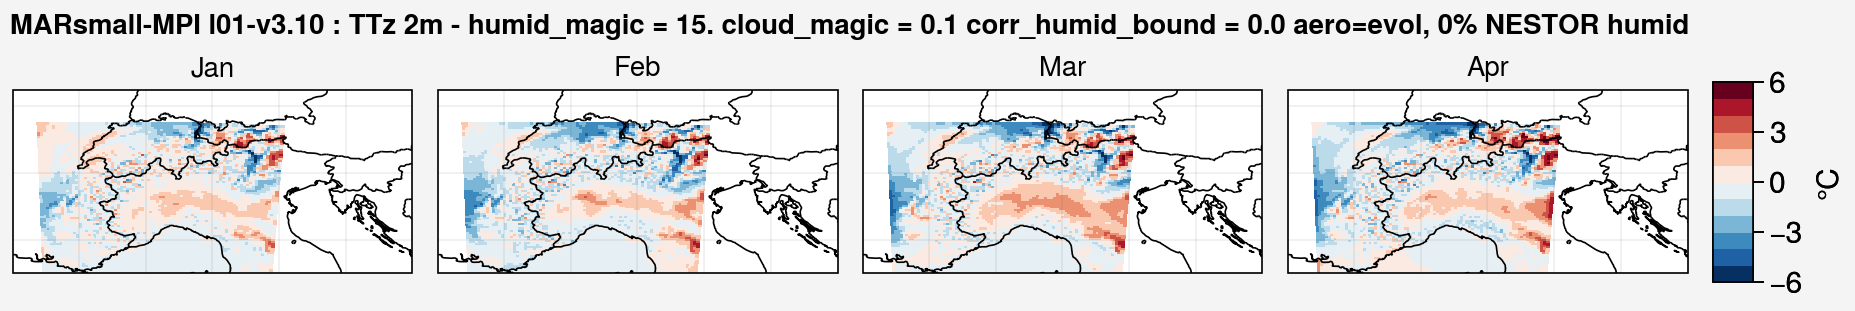

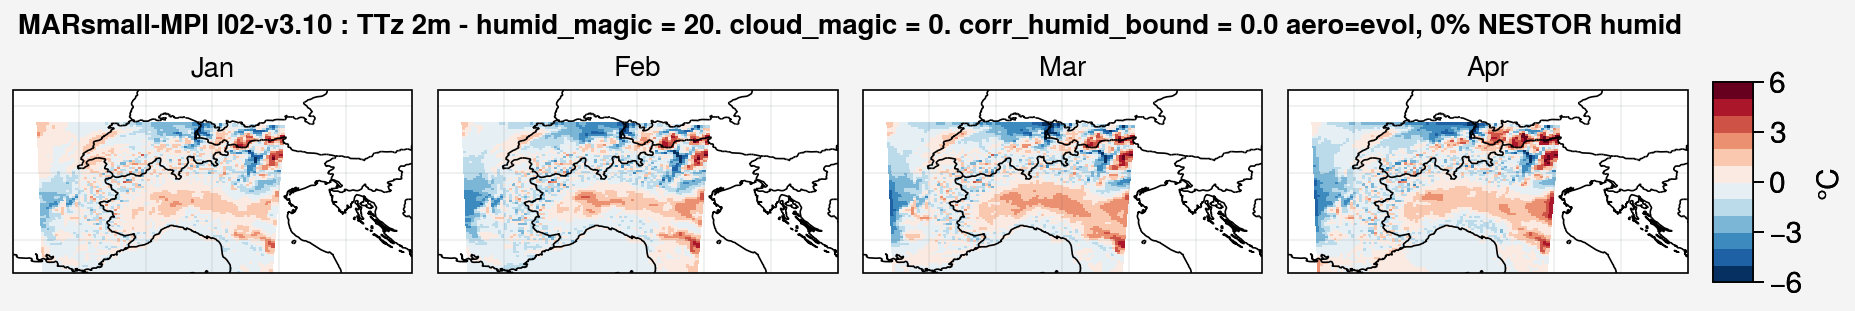

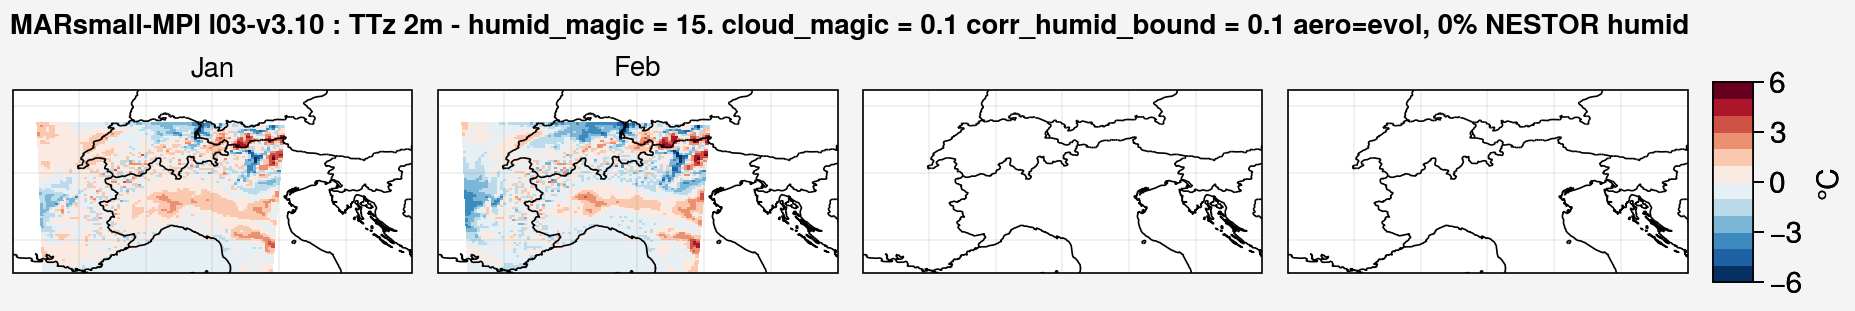

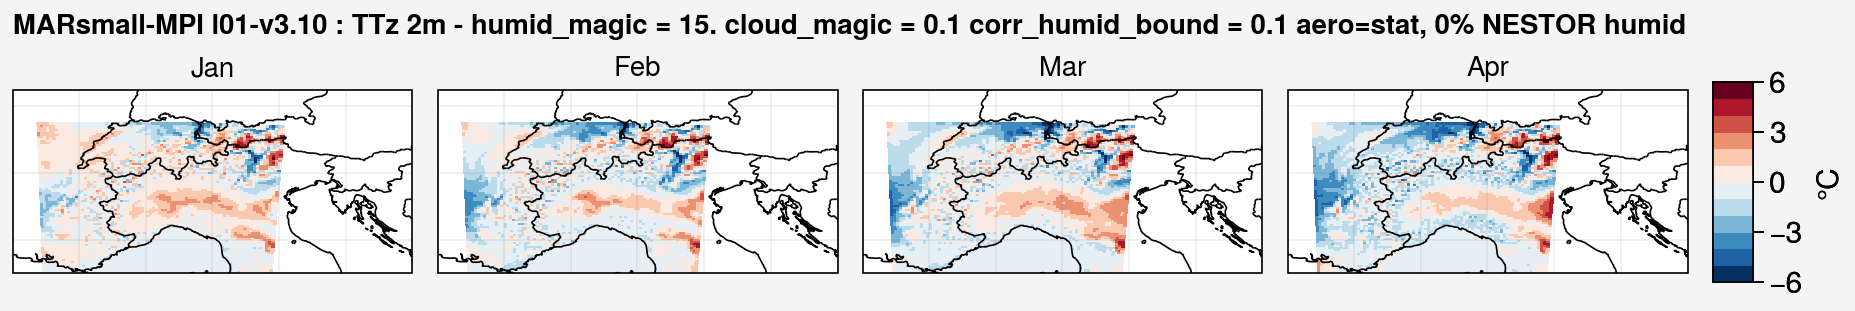

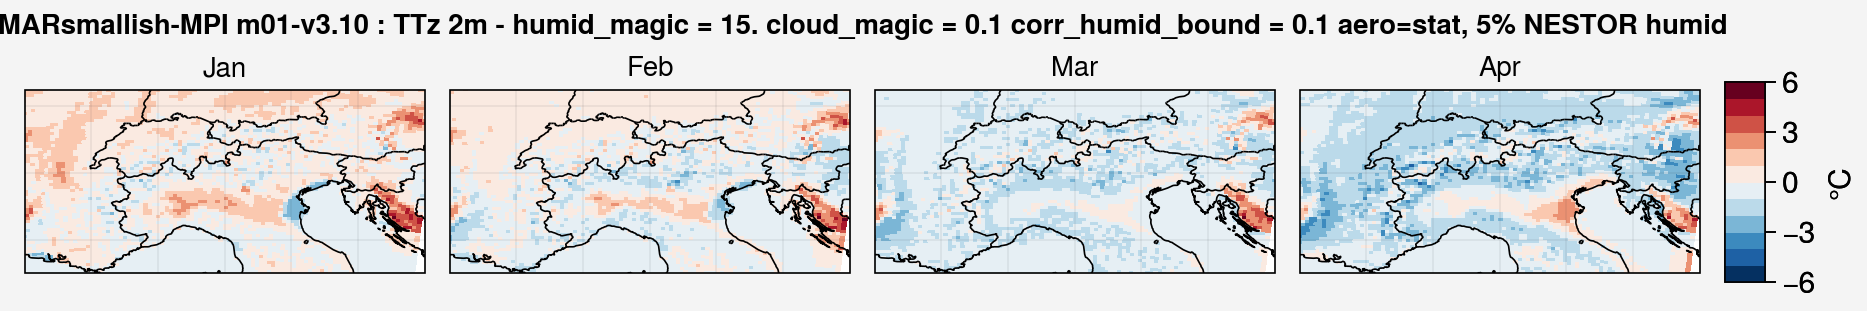

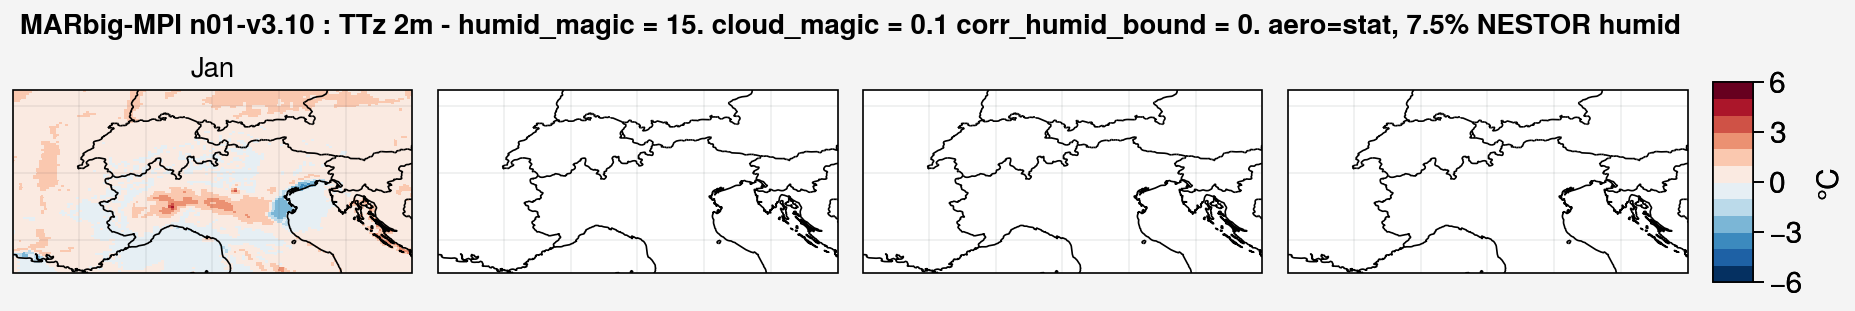

In [70]:
var = "TTz"
minval = -6
maxval = 6
Nval = 13

#l01
plot_comparison(list_ds = [ds_EUl012015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl012015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1],
                                         ds_EUl012015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[2],
                                         ds_EUl012015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [ds_EUl022015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl022015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1],
                                         ds_EUl022015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[2],
                                         ds_EUl022015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI l02-v3.10 : TTz 2m - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [ds_EUl032015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl032015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI l03-v3.10 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [ds_EUl042015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[0],
                                         ds_EUl042015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[1],
                                         ds_EUl042015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[2],
                                         ds_EUl042015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmall_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [ds_EUm012015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[0],
                                         ds_EUm012015_mon[var].isel(ztqlev=0)[1] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[1],
                                         ds_EUm012015_mon[var].isel(ztqlev=0)[2] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[2],
                                         ds_EUm012015_mon[var].isel(ztqlev=0)[3] - ds_EUy2015_regridsmallish_month[var].isel(ztqlev=0)[3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [ds_EUn012015_mon[var].isel(ztqlev=0)[0] - ds_EUy2015_month[var].isel(ztqlev=0)[0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARbig-MPI n01-v3.10 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

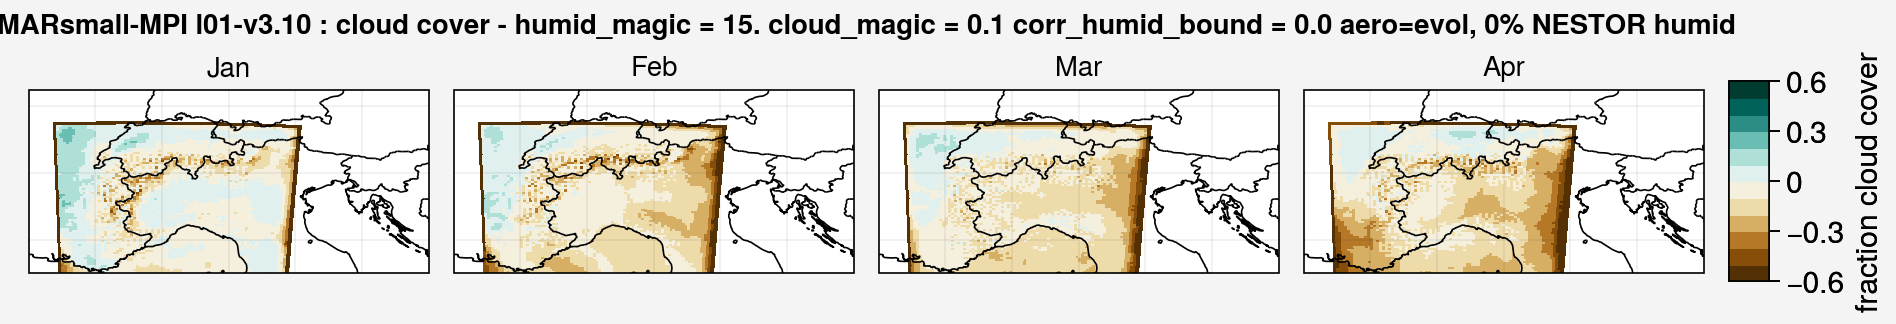

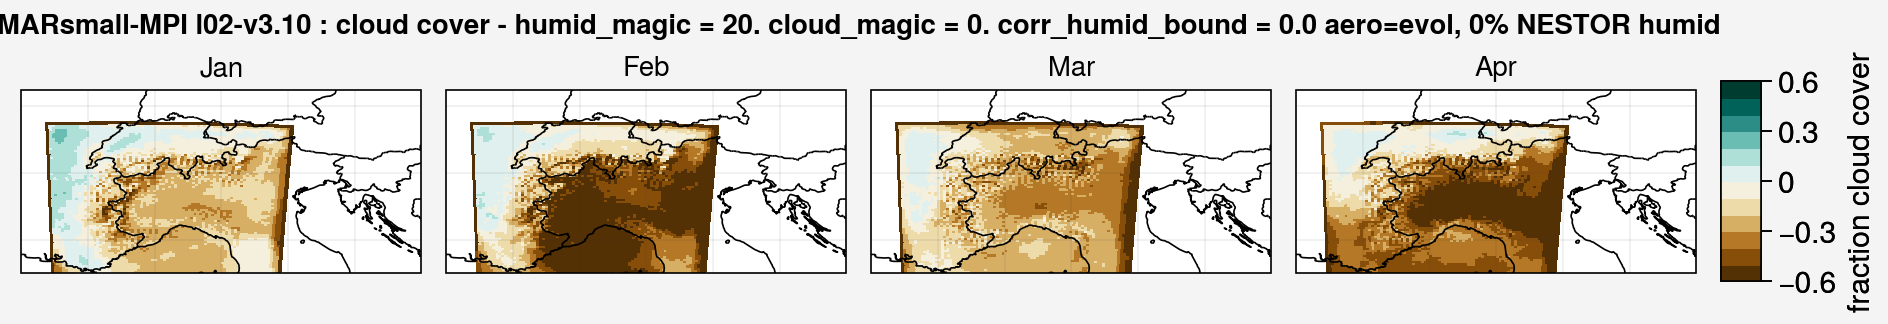

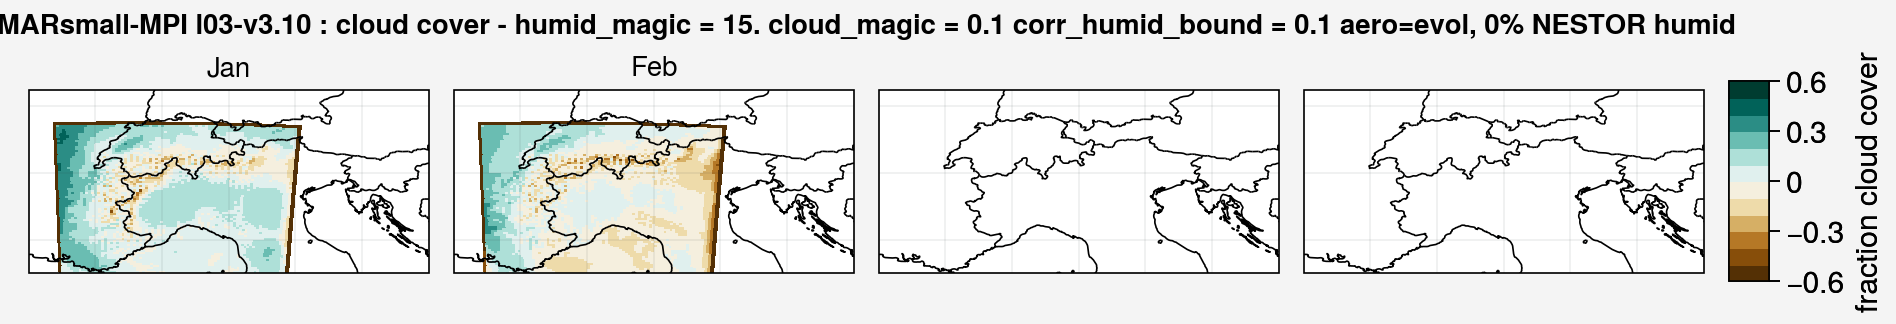

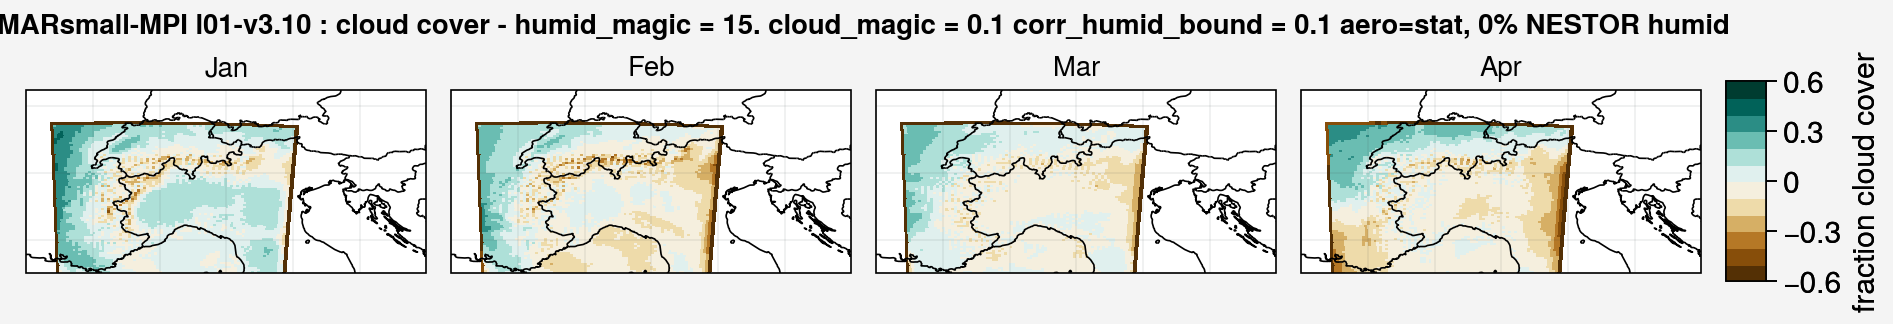

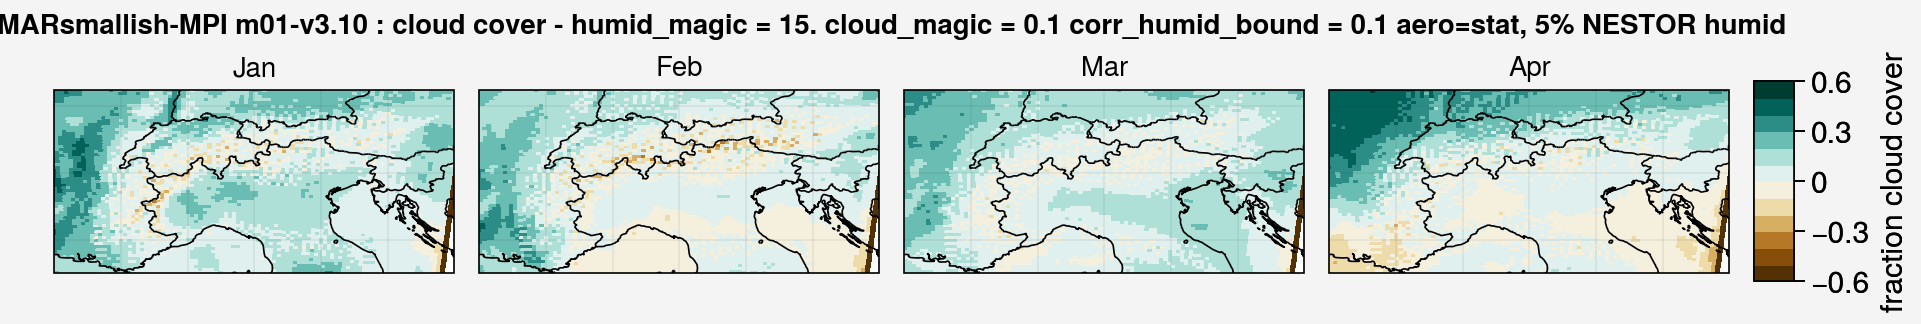

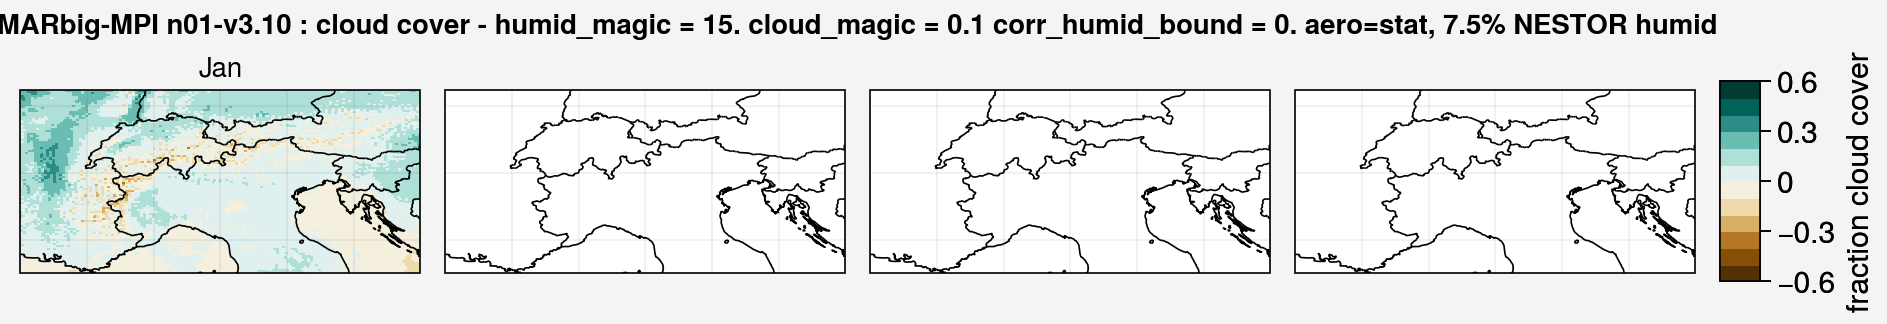

In [18]:
var = "CC"
minval = -0.6
maxval = 0.6
Nval = 13

#l01
plot_comparison(list_ds = [ds_EUl012015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl012015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl012015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl012015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : cloud cover - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [ds_EUl022015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl022015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl022015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl022015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmall-MPI l02-v3.10 : cloud cover - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [ds_EUl032015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl032015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmall-MPI l03-v3.10 : cloud cover - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [ds_EUl042015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl042015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl042015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl042015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmall-MPI l01-v3.10 : cloud cover - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [ds_EUm012015_mon[var][0] - ds_EUy2015_regridsmallish_month[var][0],
                                         ds_EUm012015_mon[var][1] - ds_EUy2015_regridsmallish_month[var][1],
                                         ds_EUm012015_mon[var][2] - ds_EUy2015_regridsmallish_month[var][2],
                                         ds_EUm012015_mon[var][3] - ds_EUy2015_regridsmallish_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : cloud cover - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [ds_EUn012015_mon[var][0] - ds_EUy2015_month[var][0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARbig-MPI n01-v3.10 : cloud cover - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

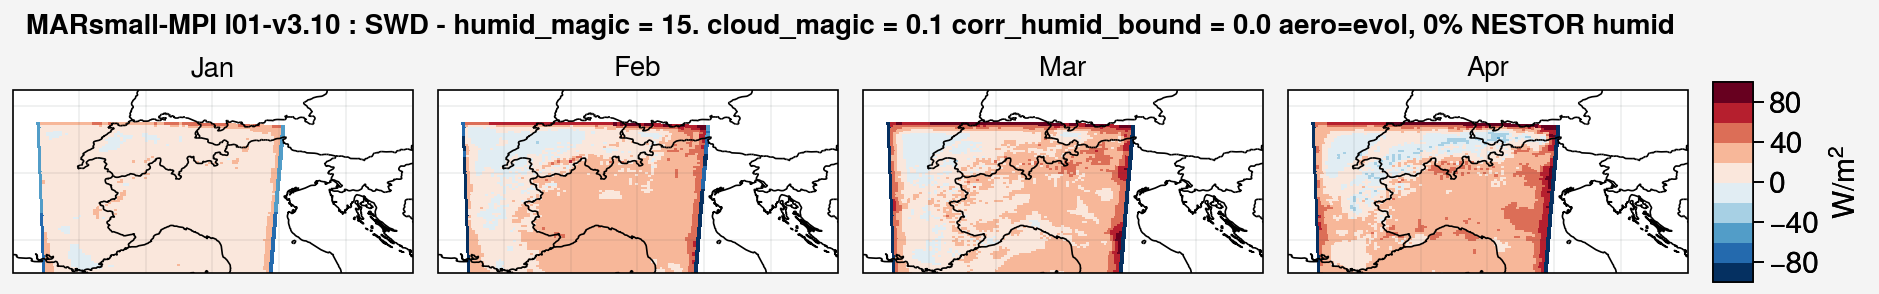

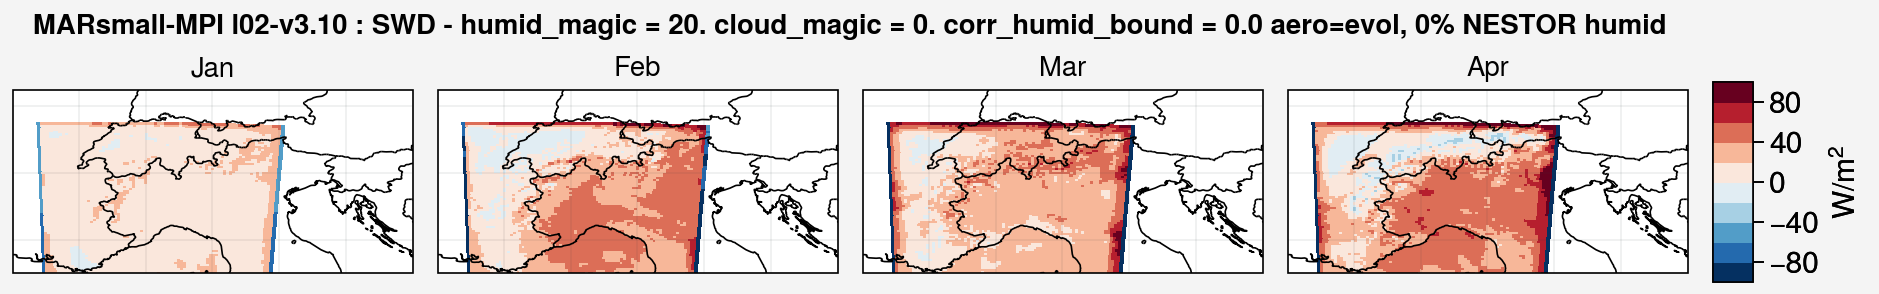

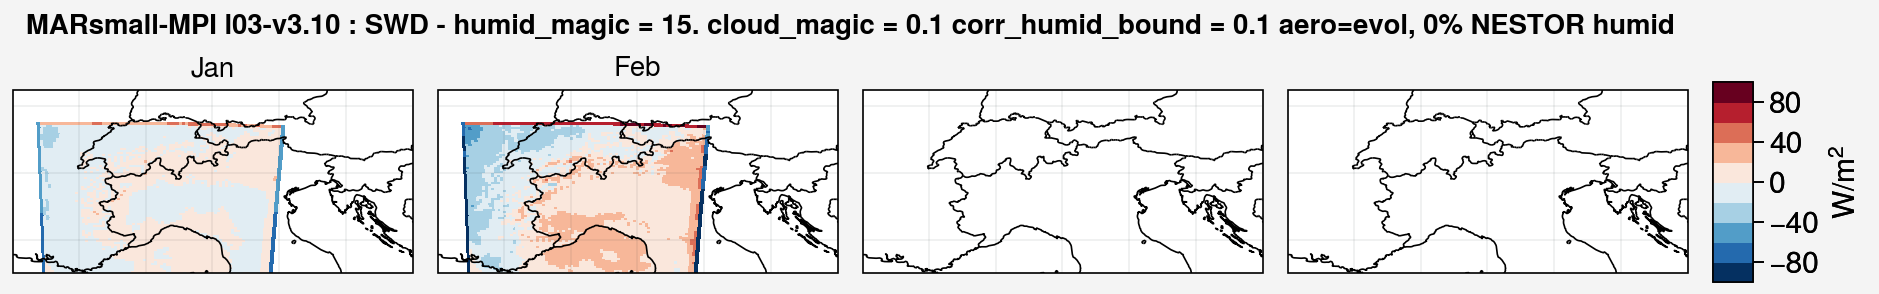

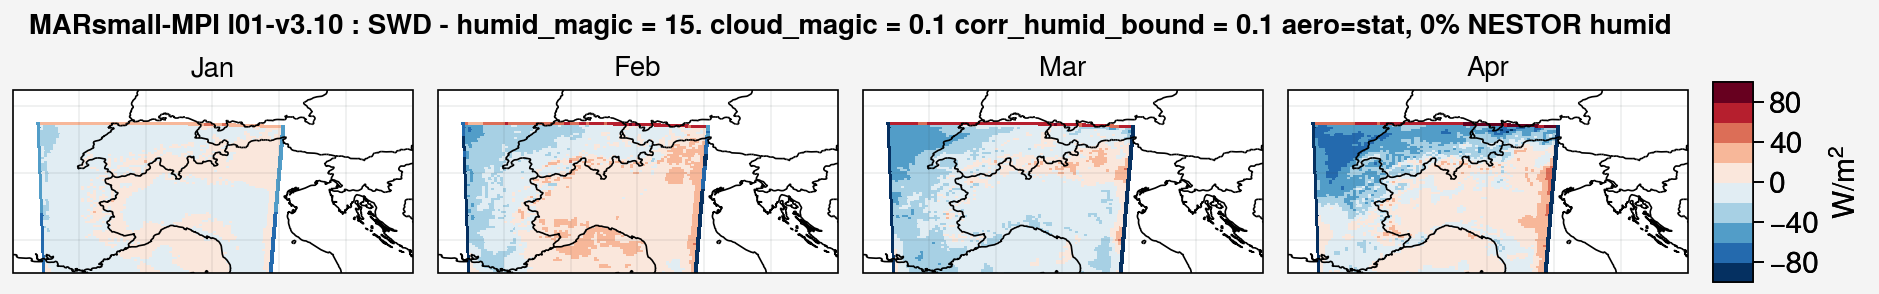

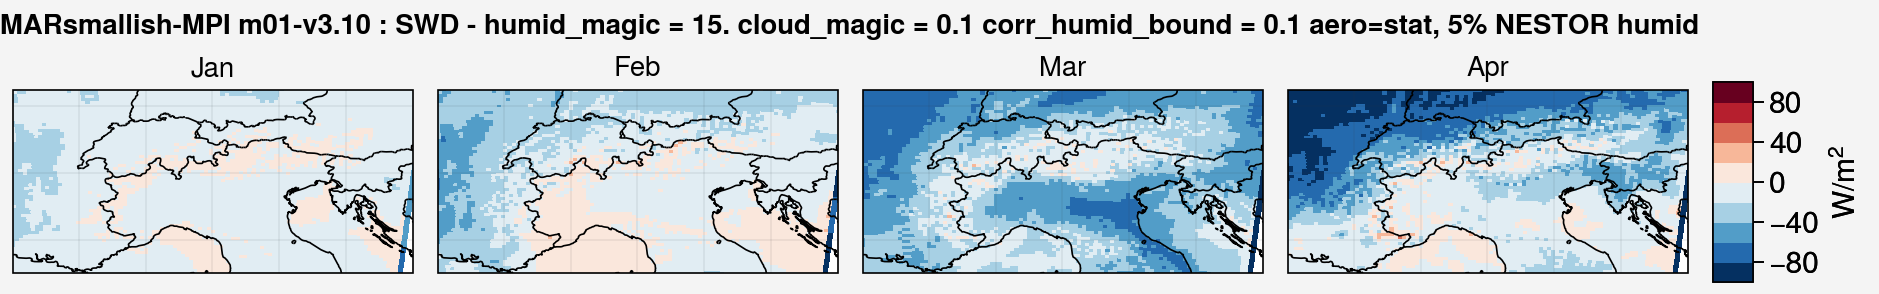

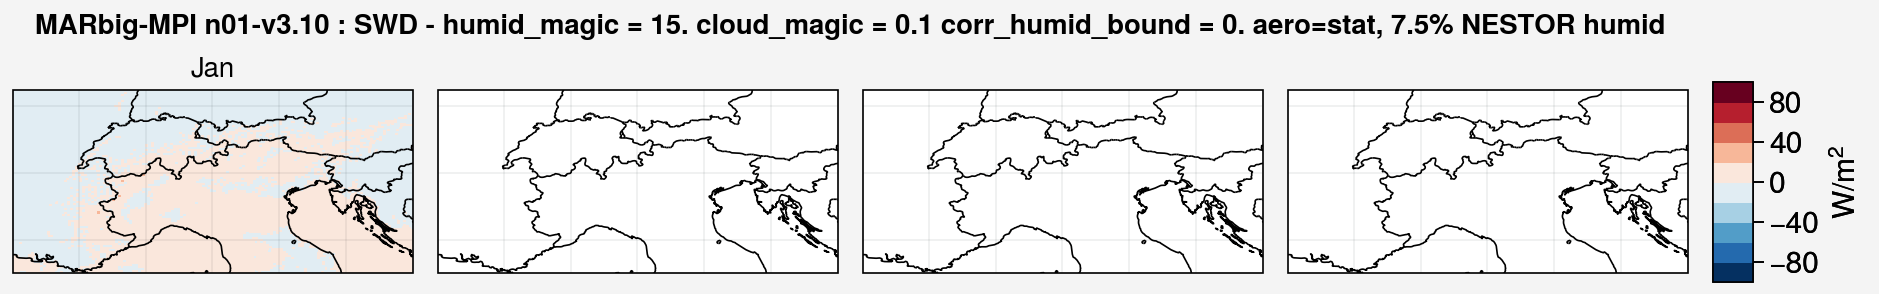

In [16]:
var = "SWD"
varlabel = "W/$m^2$"
minval = -100
maxval = 100
Nval = 11

#l01
plot_comparison(list_ds = [ds_EUl012015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl012015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl012015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl012015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [ds_EUl022015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl022015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl022015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl022015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l02-v3.10 : SWD - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [ds_EUl032015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl032015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l03-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [ds_EUl042015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0],
                                         ds_EUl042015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1],
                                         ds_EUl042015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2],
                                         ds_EUl042015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [ds_EUm012015_mon[var][0] - ds_EUy2015_regridsmallish_month[var][0],
                                         ds_EUm012015_mon[var][1] - ds_EUy2015_regridsmallish_month[var][1],
                                         ds_EUm012015_mon[var][2] - ds_EUy2015_regridsmallish_month[var][2],
                                         ds_EUm012015_mon[var][3] - ds_EUy2015_regridsmallish_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [ds_EUn012015_mon[var][0] - ds_EUy2015_month[var][0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARbig-MPI n01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

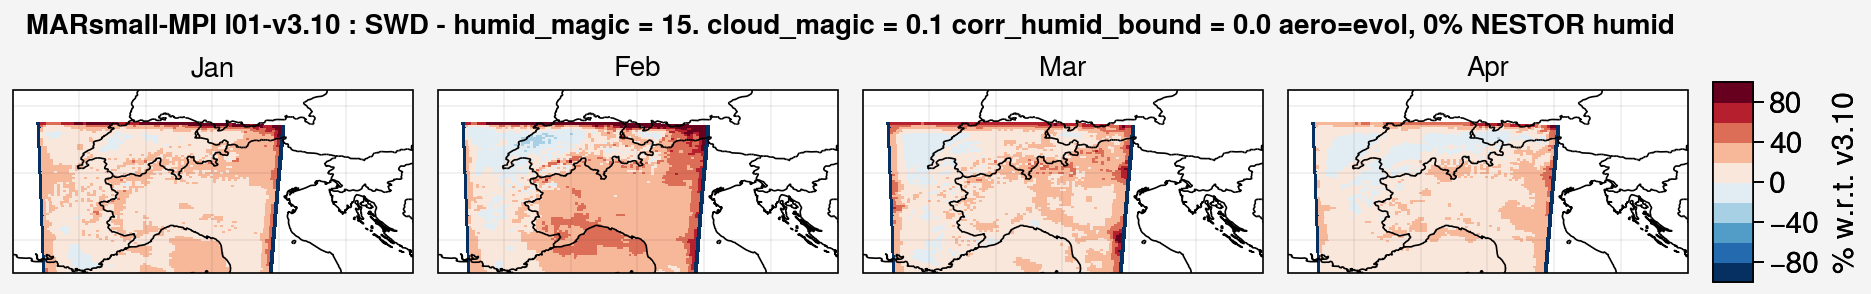

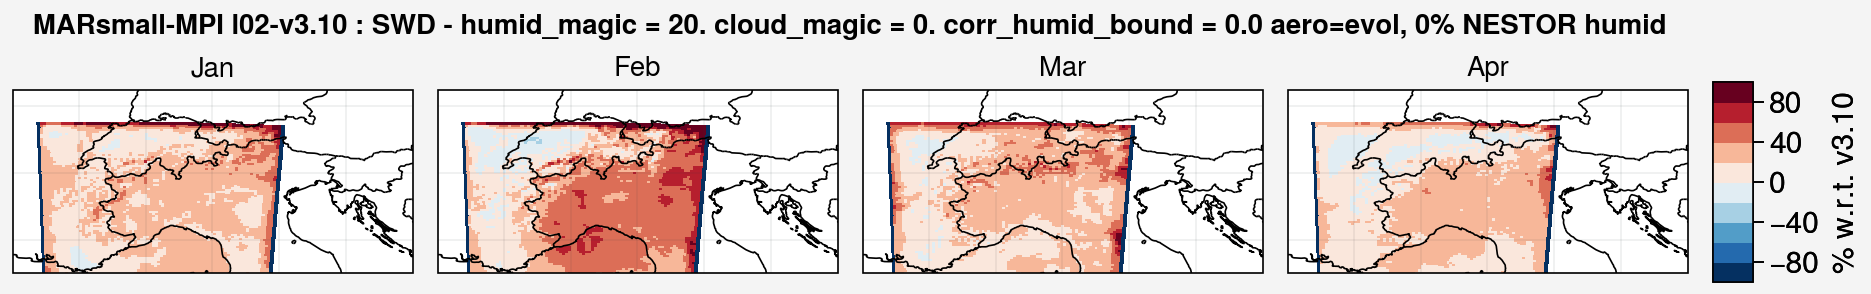

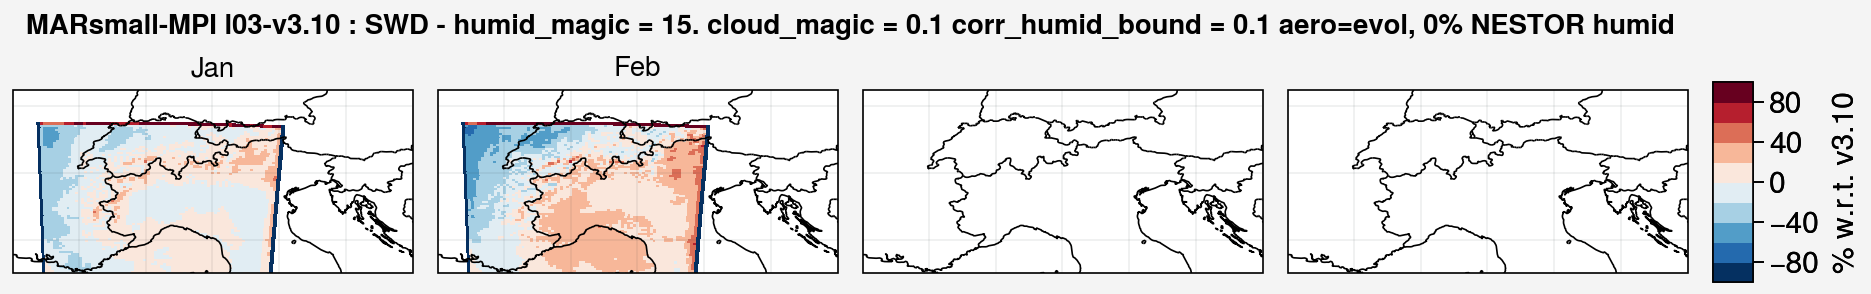

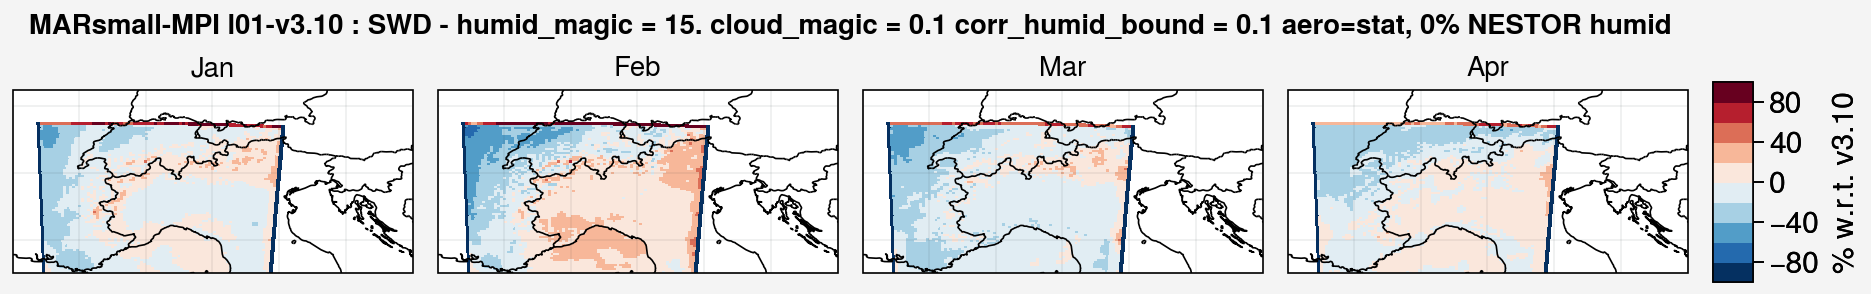

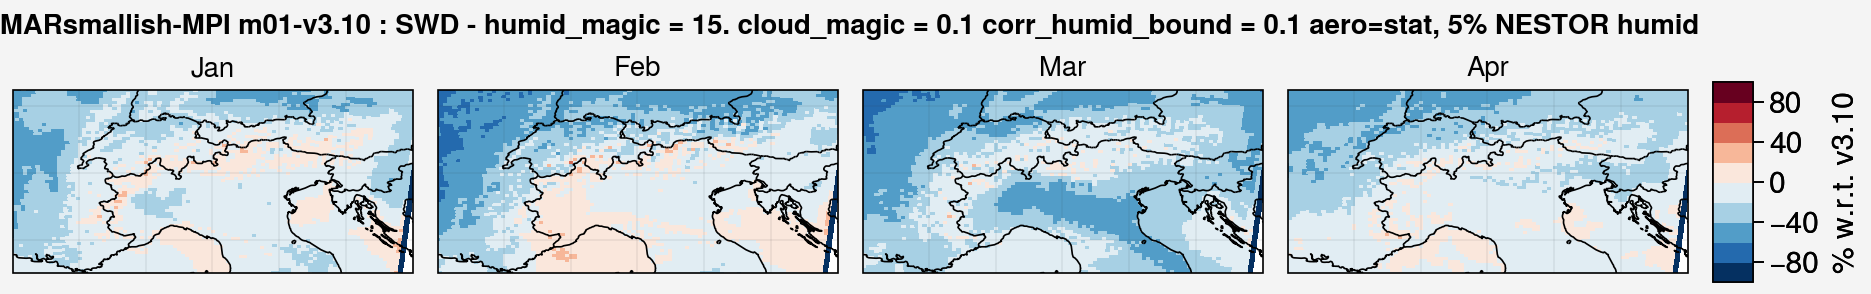

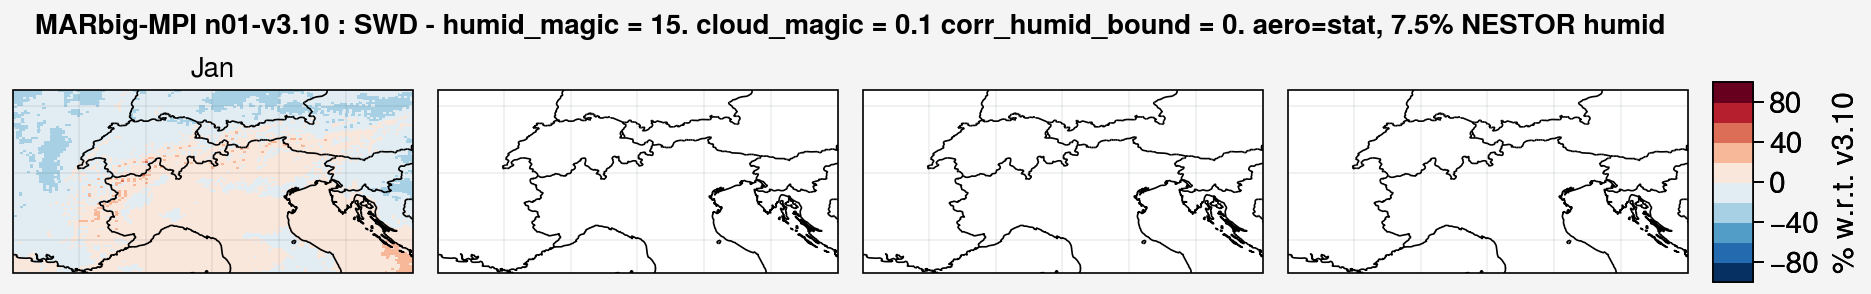

In [21]:
var = "SWD"
varlabel = "% w.r.t. v3.10"
minval = -100
maxval = 100
Nval = 11

#l01
plot_comparison(list_ds = [100*(ds_EUl012015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                           100*(ds_EUl012015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1],
                           100*(ds_EUl012015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2])/ds_EUy2015_regridsmall_month[var][2],
                           100*(ds_EUl012015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3])/ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l02
plot_comparison(list_ds = [100*(ds_EUl022015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                           100*(ds_EUl022015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1],
                           100*(ds_EUl022015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2])/ds_EUy2015_regridsmall_month[var][2],
                           100*(ds_EUl022015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3])/ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l02-v3.10 : SWD - humid_magic = 20. cloud_magic = 0. corr_humid_bound = 0.0 aero=evol, 0% NESTOR humid',
                rows=1)

#l03
plot_comparison(list_ds = [100*(ds_EUl032015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                           100*(ds_EUl032015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l03-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=evol, 0% NESTOR humid',
                rows=1)

#l04
plot_comparison(list_ds = [100*(ds_EUl042015_mon[var][0] - ds_EUy2015_regridsmall_month[var][0])/ds_EUy2015_regridsmall_month[var][0],
                           100*(ds_EUl042015_mon[var][1] - ds_EUy2015_regridsmall_month[var][1])/ds_EUy2015_regridsmall_month[var][1],
                           100*(ds_EUl042015_mon[var][2] - ds_EUy2015_regridsmall_month[var][2])/ds_EUy2015_regridsmall_month[var][2],
                           100*(ds_EUl042015_mon[var][3] - ds_EUy2015_regridsmall_month[var][3])/ds_EUy2015_regridsmall_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmall-MPI l01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 0% NESTOR humid',
                rows=1)

#m01
plot_comparison(list_ds = [100*(ds_EUm012015_mon[var][0] - ds_EUy2015_regridsmallish_month[var][0])/ds_EUy2015_regridsmallish_month[var][0],
                           100*(ds_EUm012015_mon[var][1] - ds_EUy2015_regridsmallish_month[var][1])/ds_EUy2015_regridsmallish_month[var][1],
                           100*(ds_EUm012015_mon[var][2] - ds_EUy2015_regridsmallish_month[var][2])/ds_EUy2015_regridsmallish_month[var][2],
                           100*(ds_EUm012015_mon[var][3] - ds_EUy2015_regridsmallish_month[var][3])/ds_EUy2015_regridsmallish_month[var][3]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#n01
plot_comparison(list_ds = [100*(ds_EUn012015_mon[var][0] - ds_EUy2015_month[var][0])/ds_EUy2015_month[var][0]],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'],min = minval,max = maxval,N=Nval,colormap = 'RdBu_r',label_var = varlabel,
                suptitle_var = 'MARbig-MPI n01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,ds_size=ds_big)

In [20]:
ds_EUl012015_precip_mon

<xarray.Dataset>
Dimensions:  (month: 4, y: 80, x: 80)
Coordinates:
  * x        (x) float32 -168.0 -161.0 -154.0 -147.0 ... 364.0 371.0 378.0 385.0
  * y        (y) float32 -273.0 -266.0 -259.0 -252.0 ... 259.0 266.0 273.0 280.0
  * month    (month) int64 1 2 3 4
Data variables:
    MBrr     (month, y, x) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    MBsf     (month, y, x) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    precip   (month, y, x) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
Attributes:
    title:        ICE - Exp: l01 - 20150101
    institution:  ULg (Xavier Fettweis)
    history:      libUN (2005.04.08) - Tue Jun 24 14:36:56 2025
    netcdf:       4.8.0 of May  2 2023 12:43:48 $

### m02 : 100x90 domain, no humid correction at the boundary in marmagic (still 5% in NESTOR)

In [28]:
vars_list = ["SWU","SWD","CC","QQz","TTz","ST"]
ds_EUm012014 = open_monthly_data_ave(vars=vars_list,year='2014',month=['09','10','11','12'],days_in_month=['30','31','30','31'],sim='m01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm022014 = open_monthly_data_ave(vars=vars_list,year='2014',month=['09','10','11','12'],days_in_month=['30','31','30','31'],sim='m02',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

vars_list = ["MBrr","MBsf"]
ds_EUm012014_precip = open_monthly_data_ave(vars=vars_list,year='2014',month=['09','10','11','12'],days_in_month=['30','31','30','31'],sim='m01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

ds_EUm022014_precip = open_monthly_data_ave(vars=vars_list,year='2014',month=['09','10','11','12'],days_in_month=['30','31','30','31'],sim='m02',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True)

In [29]:
ds_EUm012014 = ds_EUm012014.resample(time='D').mean()
ds_EUm012014_precip = ds_EUm012014_precip.resample(time='D').sum()
ds_EUm012014_mon = ds_EUm012014.groupby("time.month").mean()
ds_EUm012014_precip_mon = ds_EUm012014_precip.groupby("time.month").mean()

ds_EUm022014 = ds_EUm022014.resample(time='D').mean()
ds_EUm022014_precip = ds_EUm022014_precip.resample(time='D').sum()
ds_EUm022014_mon = ds_EUm022014.groupby("time.month").mean()
ds_EUm022014_precip_mon = ds_EUm022014_precip.groupby("time.month").mean()

In [20]:
# Regridding MARv3.10 onto small domain

# MAR has a very slight difference in x and y positions of grid cells between MARgrid and the simulations, which will prevent the regridding. So have to do this :
lon_correct_xy = ds.LON # copy the incorrect lon/lat
lat_correct_xy = ds.LAT
#lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

lon_correct_xy["x"] = ("x", ds_EUy2014.x.values) # correct lon
lon_correct_xy["y"] = ("y", ds_EUy2014.y.values)

lat_correct_xy["x"] = ("x", ds_EUy2014.x.values) # correct lat
lat_correct_xy["y"] = ("y", ds_EUy2014.y.values)

ds_EUy2014.coords['lon'] = lon_correct_xy
ds_EUy2014.coords['lat'] = lat_correct_xy

ds_EUy2014_regridsmall = u.regrid(ds_EUy2014,ds_small,'bilinear',globe=True,periodic=False,reuse_weights=False)
ds_EUy2014_regridsmallish = u.regrid(ds_EUy2014,ds_smallish,'bilinear',globe=True,periodic=False,reuse_weights=False)

In [21]:
ds_EUy2014_month = ds_EUy2014.groupby("time.month").mean()
ds_EUy2014_regridsmall_month = ds_EUy2014_regridsmall.groupby("time.month").mean()
ds_EUy2014_regridsmallish_month = ds_EUy2014_regridsmallish.groupby("time.month").mean()

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

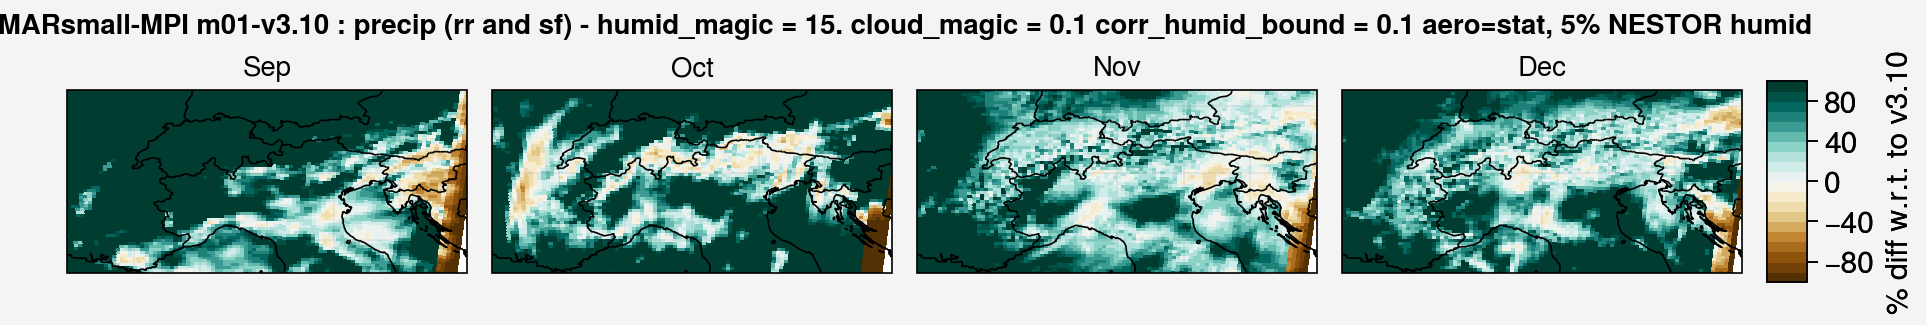

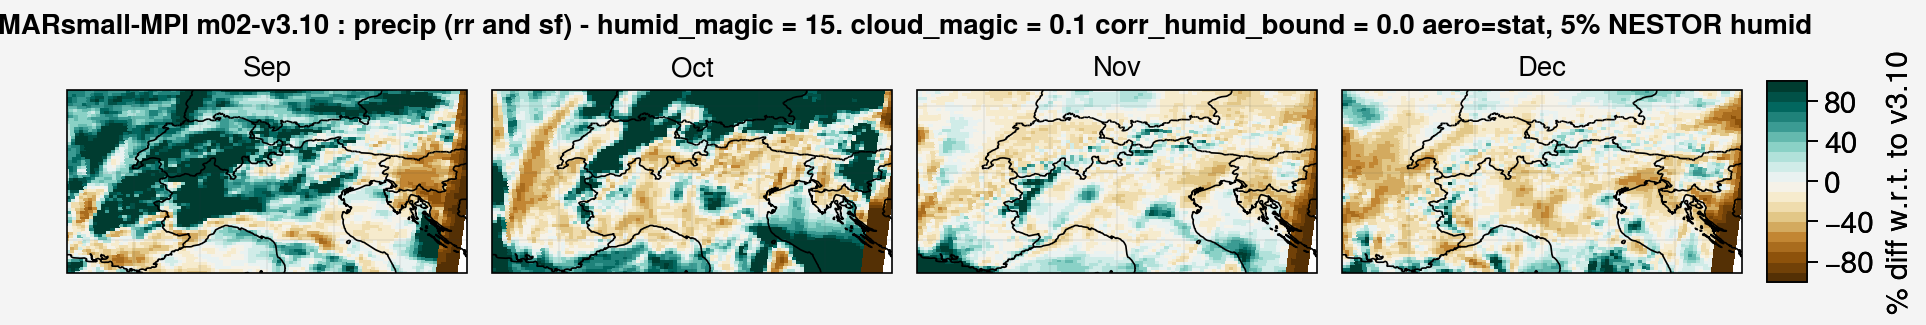

In [30]:
var = "precip"

#m01
plot_comparison(list_ds = [100*(ds_EUm012014_precip_mon[var][0] - ds_EUy2014_regridsmallish_month[var][8])/ds_EUy2014_regridsmallish_month[var][8],
                           100*(ds_EUm012014_precip_mon[var][1] - ds_EUy2014_regridsmallish_month[var][9])/ds_EUy2014_regridsmallish_month[var][9],
                           100*(ds_EUm012014_precip_mon[var][2] - ds_EUy2014_regridsmallish_month[var][10])/ds_EUy2014_regridsmallish_month[var][10],
                           100*(ds_EUm012014_precip_mon[var][3] - ds_EUy2014_regridsmallish_month[var][11])/ds_EUy2014_regridsmallish_month[var][11]],
                months = ['Sep','Oct','Nov','Dec'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI m01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
plot_comparison(list_ds = [100*(ds_EUm022014_precip_mon[var][0] - ds_EUy2014_regridsmallish_month[var][8])/ds_EUy2014_regridsmallish_month[var][8],
                           100*(ds_EUm022014_precip_mon[var][1] - ds_EUy2014_regridsmallish_month[var][9])/ds_EUy2014_regridsmallish_month[var][9],
                           100*(ds_EUm022014_precip_mon[var][2] - ds_EUy2014_regridsmallish_month[var][10])/ds_EUy2014_regridsmallish_month[var][10],
                           100*(ds_EUm022014_precip_mon[var][3] - ds_EUy2014_regridsmallish_month[var][11])/ds_EUy2014_regridsmallish_month[var][11]],
                months = ['Sep','Oct','Nov','Dec'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI m02-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

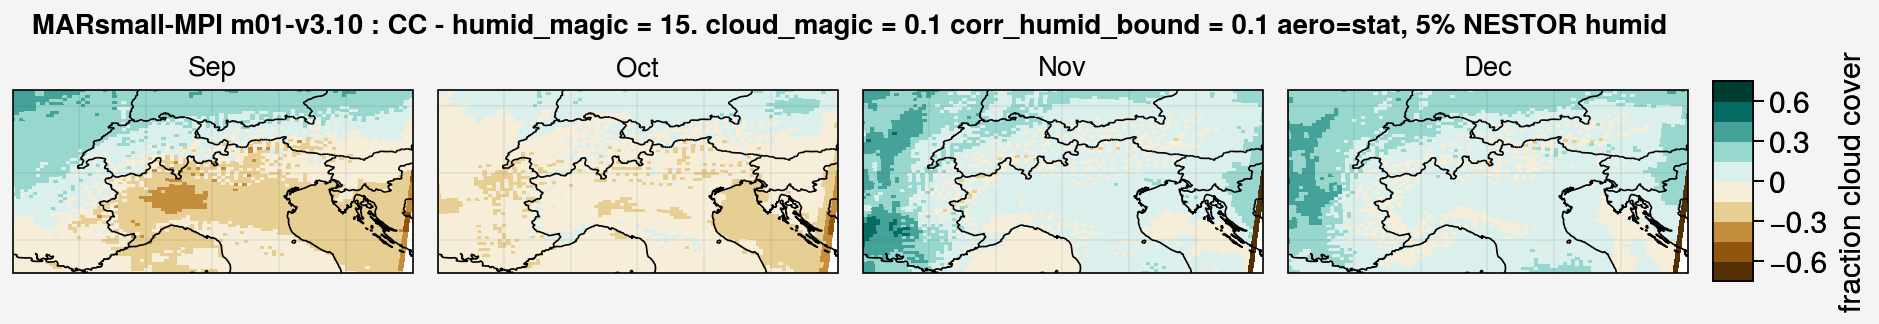

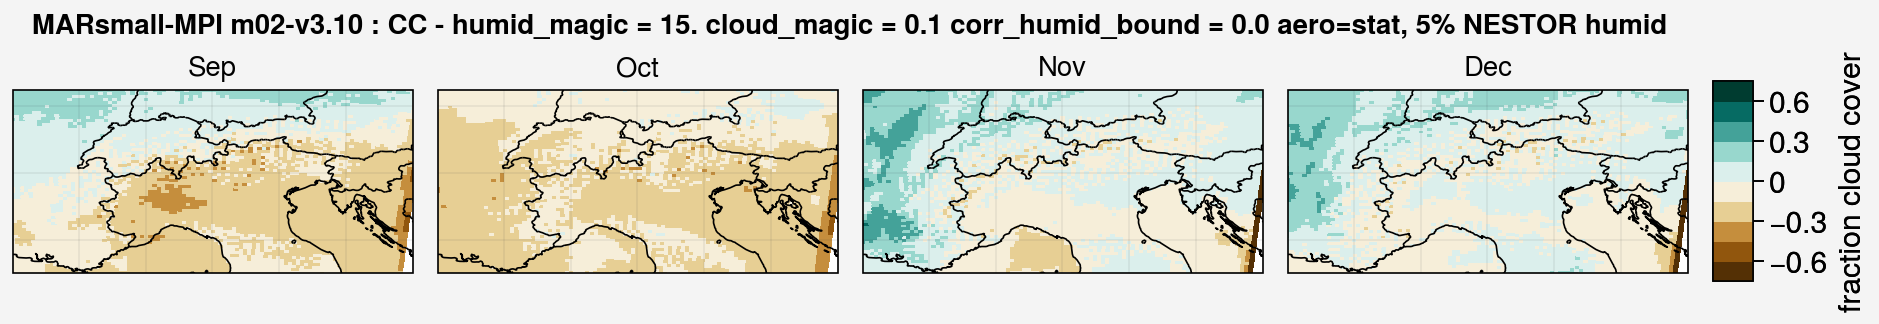

In [31]:
var = "CC"

#m01
plot_comparison(list_ds = [ds_EUm012014_mon[var][0] - ds_EUy2014_regridsmallish_month[var][8],
                           ds_EUm012014_mon[var][1] - ds_EUy2014_regridsmallish_month[var][9],
                           ds_EUm012014_mon[var][2] - ds_EUy2014_regridsmallish_month[var][10],
                           ds_EUm012014_mon[var][3] - ds_EUy2014_regridsmallish_month[var][11]],
                months = ['Sep','Oct','Nov','Dec'],min = -0.75,max = 0.75,N=11,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmall-MPI m01-v3.10 : CC - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
plot_comparison(list_ds = [ds_EUm022014_mon[var][0] - ds_EUy2014_regridsmallish_month[var][8],
                           ds_EUm022014_mon[var][1] - ds_EUy2014_regridsmallish_month[var][9],
                           ds_EUm022014_mon[var][2] - ds_EUy2014_regridsmallish_month[var][10],
                           ds_EUm022014_mon[var][3] - ds_EUy2014_regridsmallish_month[var][11]],
                months = ['Sep','Oct','Nov','Dec'],min = -0.75,max = 0.75,N=11,colormap = 'BrBG',label_var = 'fraction cloud cover',
                suptitle_var = 'MARsmall-MPI m02-v3.10 : CC - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

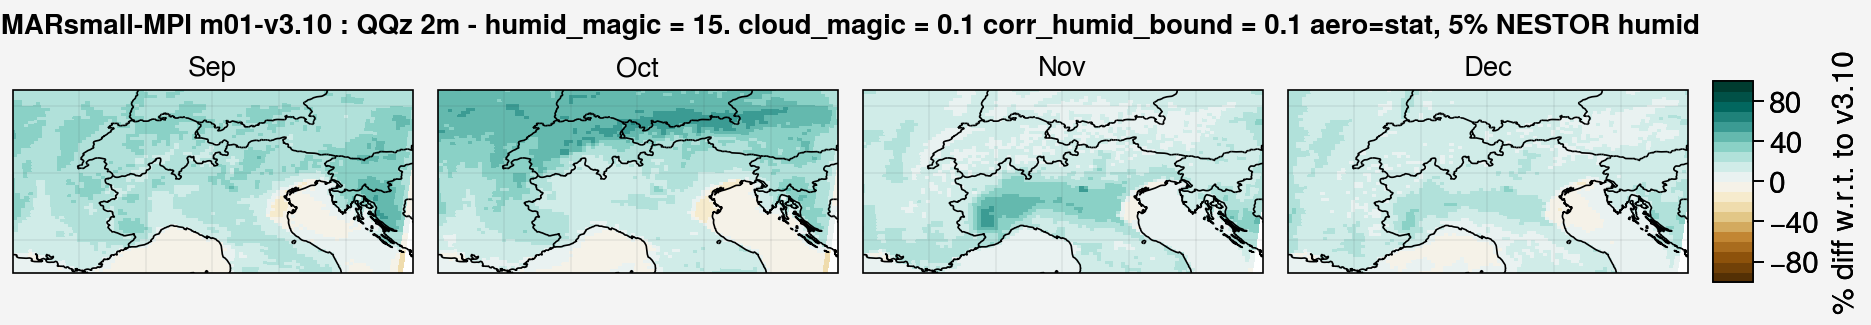

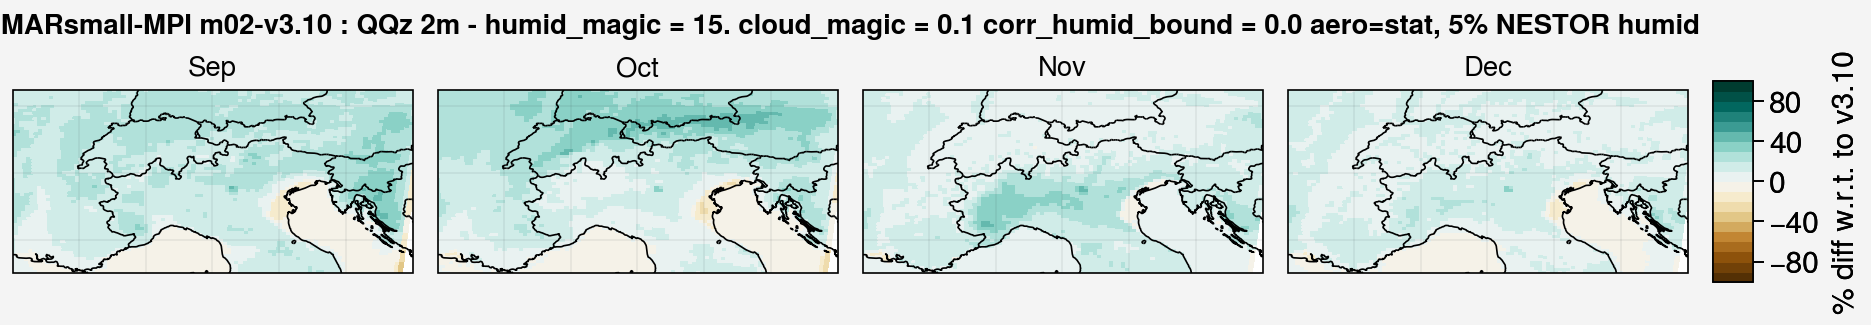

In [35]:
var = "QQz"

#m01
plot_comparison(list_ds = [100*(ds_EUm012014_mon[var].isel(ztqlev=0)[0] - ds_EUy2014_regridsmallish_month[var][8,0])/ds_EUy2014_regridsmallish_month[var][8,0],
                           100*(ds_EUm012014_mon[var].isel(ztqlev=0)[1] - ds_EUy2014_regridsmallish_month[var][9,0])/ds_EUy2014_regridsmallish_month[var][9,0],
                           100*(ds_EUm012014_mon[var].isel(ztqlev=0)[2] - ds_EUy2014_regridsmallish_month[var][10,0])/ds_EUy2014_regridsmallish_month[var][10,0],
                           100*(ds_EUm012014_mon[var].isel(ztqlev=0)[3] - ds_EUy2014_regridsmallish_month[var][11,0])/ds_EUy2014_regridsmallish_month[var][11,0]],
                months = ['Sep','Oct','Nov','Dec'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI m01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
plot_comparison(list_ds = [100*(ds_EUm022014_mon[var].isel(ztqlev=0)[0] - ds_EUy2014_regridsmallish_month[var][8,0])/ds_EUy2014_regridsmallish_month[var][8,0],
                           100*(ds_EUm022014_mon[var].isel(ztqlev=0)[1] - ds_EUy2014_regridsmallish_month[var][9,0])/ds_EUy2014_regridsmallish_month[var][9,0],
                           100*(ds_EUm022014_mon[var].isel(ztqlev=0)[2] - ds_EUy2014_regridsmallish_month[var][10,0])/ds_EUy2014_regridsmallish_month[var][10,0],
                           100*(ds_EUm022014_mon[var].isel(ztqlev=0)[3] - ds_EUy2014_regridsmallish_month[var][11,0])/ds_EUy2014_regridsmallish_month[var][11,0]],
                months = ['Sep','Oct','Nov','Dec'],min = -100,max = 100,N=21,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmall-MPI m02-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.0 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

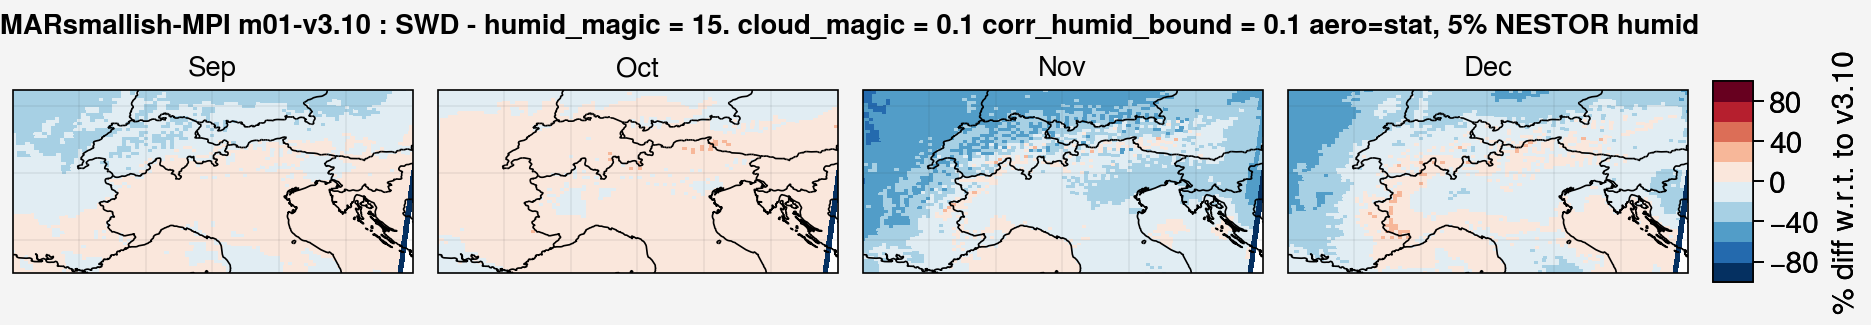

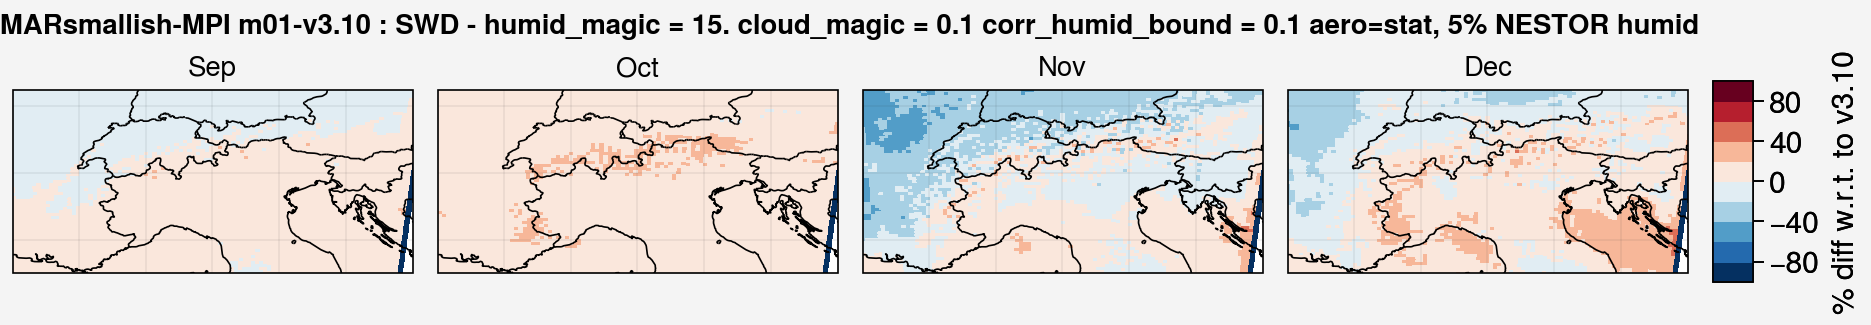

In [39]:
var = "SWD"

#m01
plot_comparison(list_ds = [100*(ds_EUm012014_mon[var][0] - ds_EUy2014_regridsmallish_month[var][8])/ds_EUy2014_regridsmallish_month[var][8],
                           100*(ds_EUm012014_mon[var][1] - ds_EUy2014_regridsmallish_month[var][9])/ds_EUy2014_regridsmallish_month[var][9],
                           100*(ds_EUm012014_mon[var][2] - ds_EUy2014_regridsmallish_month[var][10])/ds_EUy2014_regridsmallish_month[var][10],
                           100*(ds_EUm012014_mon[var][3] - ds_EUy2014_regridsmallish_month[var][11])/ds_EUy2014_regridsmallish_month[var][11]],
                months = ['Sep','Oct','Nov','Dec'],min = -100,max = 100,N=11,colormap = 'RdBu_r',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)

#m02
plot_comparison(list_ds = [100*(ds_EUm022014_mon[var][0] - ds_EUy2014_regridsmallish_month[var][8])/ds_EUy2014_regridsmallish_month[var][8],
                           100*(ds_EUm022014_mon[var][1] - ds_EUy2014_regridsmallish_month[var][9])/ds_EUy2014_regridsmallish_month[var][9],
                           100*(ds_EUm022014_mon[var][2] - ds_EUy2014_regridsmallish_month[var][10])/ds_EUy2014_regridsmallish_month[var][10],
                           100*(ds_EUm022014_mon[var][3] - ds_EUy2014_regridsmallish_month[var][11])/ds_EUy2014_regridsmallish_month[var][11]],
                months = ['Sep','Oct','Nov','Dec'],min = -100,max = 100,N=11,colormap = 'RdBu_r',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARsmallish-MPI m01-v3.10 : SWD - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0.1 aero=stat, 5% NESTOR humid',
                rows=1,ds_size=ds_smallish)